In [2]:
%pip install swiftsimio==6.1.1 numpy==1.26.0 unyt==2.9.5 pillow

import matplotlib.pyplot as plt
import swiftsimio as sw
import h5py
import numpy as np
import woma
import os
from matplotlib.animation import FuncAnimation
from PIL import Image

Note: you may need to restart the kernel to use updated packages.


Loaded 160051 particles with material IDs from GasParticles/Coordinates
Plot saved as final_results/b=0.85/n=3\plots\coll3_0300.png


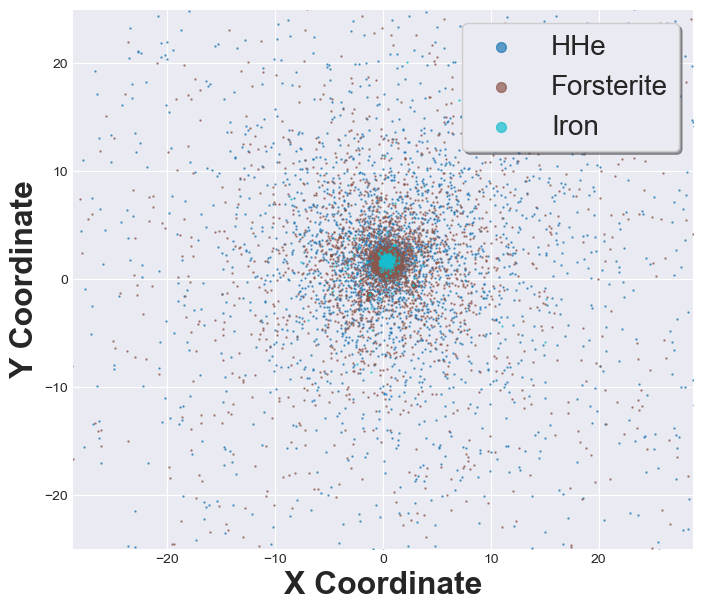

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

## Function that plots the postition of each particle within a certain plot range for a frame, for 3d or 2d

def init_plot(file, coord, matid, plot_range, projection="3d"):
    
    plt.style.use('seaborn-v0_8-darkgrid')

    # Extract the directory and base name of the HDF5 file
    dir = os.path.dirname(file)
    base_name = os.path.splitext(os.path.basename(file))[0]

    # Define new 'plots' folder that figures will be saved in
    plots_folder = os.path.join(dir, "plots")
    os.makedirs(plots_folder, exist_ok=True) 

    # Define the output file path
    output_file = os.path.join(plots_folder, f"{base_name}.png")

    # Open hdf5 file
    with h5py.File(file, "r") as file:
        coordinates = file[coord][:]
        material_ids = file[matid][:]
        print(f"Loaded {len(coordinates)} particles with material IDs from {coord}")

    # Calculate center of mass
    com = np.mean(coordinates, axis=0)

    # Centre to COM
    coord_cent = coordinates - com
    x, y, z = coord_cent[:, 0], coord_cent[:, 1], coord_cent[:, 2]

    # Define plot range 
    limits = (-plot_range / 2, plot_range / 2)

    # Material IDs and specific colours
    mat_col = {
        200: ("#1f77b4", "HHe"),       # Blue
        400: ("#8c564b", "Forsterite"), # Brown
        401: ("#17becf", "Iron")        # Cyan
    }

    
    # Plot the data
    fontsize = 25
    fig = plt.figure(figsize=(8, 7))
    # 3D Plot 
    if projection == "3d":
        ax = fig.add_subplot(111, projection='3d')
        for material_id, (colour, label) in mat_col.items():
            # Filter and plot particles by material ID 
            mask = (material_ids == material_id)
            if np.any(mask):
                ax.scatter(x[mask], y[mask], z[mask], s=1, color=colour, alpha=0.7, label=label)
        ax.set_xlim(limits)
        ax.set_ylim(limits)
        ax.set_zlim(limits)
        ax.set_xlabel("X Coordinate (Centered)")
        ax.set_ylabel("Y Coordinate (Centered)")
        ax.set_zlabel("Z Coordinate (Centered)")
        ax.set_title("3D Particle Positions by Material ID (Centered on COM)")

        # Equal scaling
        ax.set_box_aspect([1, 1, 1])
    # 2D Plot
    elif projection == "2d":
        ax = fig.add_subplot(111)
        # Iterates over keys and items
        for material_id, (colour, label) in mat_col.items():
            # Filter and plot particles by material ID
            mask = (material_ids == material_id)
            if np.any(mask):
                ax.scatter(x[mask], y[mask], s=0.5, color=colour, alpha=0.7, label=label)
        ax.set_xlim(limits)
        ax.set_ylim(limits)
        ax.set_xlabel("X Coordinate", fontsize=fontsize-2, fontweight='bold')
        ax.set_ylabel("Y Coordinate", fontsize=fontsize-2, fontweight='bold')
        # ax.set_title("2D Particle Positions by Material ID", fontsize=fontsize)

        # Equal scaling
        ax.set_aspect('equal', adjustable='datalim')
    

    ax.legend(loc="upper right", markerscale=10, fontsize=fontsize-5, frameon=True, shadow=True)
    # plt.grid(True)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved as {output_file}")

    # plt.show()
    # plt.close(fig) # Comment out to show figure in notebook

init_plot(
            "final_results/b=0.85/n=3/coll3_0300.hdf5",
            "GasParticles/Coordinates",
            "GasParticles/MaterialIDs",
            plot_range=50,
            projection="2d"
         )



# for i in range(0,226):
#     init_plot(
#             f"final_results/b=0.85/n=3/coll2_{i:04d}.hdf5",
#             "GasParticles/Coordinates",
#             "GasParticles/MaterialIDs",
#             plot_range=12,
#             projection="2d"
#          )
# for i in range(0,226):
#     init_plot(
#             f"final_results/b=0.75/n=4/coll2_{i:04d}.hdf5",
#             "GasParticles/Coordinates",
#             "GasParticles/MaterialIDs",
#             plot_range=12,
#             projection="2d"
#         )
# for i in range(0,226):
#     init_plot(
#             f"final_results/b=0.75/n=4/coll3_{i:04d}.hdf5",
#             "GasParticles/Coordinates",
#             "GasParticles/MaterialIDs",
#             plot_range=12,
#             projection="2d"
#         )
    
# for i in range(0,226):
#     init_plot(
#             f"final_results/b=0.75/n=4/coll4_{i:04d}.hdf5",
#             "GasParticles/Coordinates",
#             "GasParticles/MaterialIDs",
#             plot_range=12,
#             projection="2d"
#         )

In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt


## Function that filters out non-gravitationally bound paritcles

def compute_bound_particles(coordinates, velocities, masses, potentials, internal_energies):
    
    # Compute center of mass and center-of-mass velocity
    total_mass = np.sum(masses)
    com = np.sum(masses[:, None] * coordinates, axis=0) / total_mass
    v_com = np.sum(masses[:, None] * velocities, axis=0) / total_mass

    # Adjust coordinates and velocities relative to the COM
    coord_cent = coordinates - com
    vel_cent = velocities - v_com
        
    # Compute kinetic energy using new centred velocities
    ke = 0.5 * masses * np.sum(vel_cent**2, axis=1)
   
    # Compute total energy
    total_energy = ke + internal_energies + potentials

    # Find gravitationally bound particles (where total energy < 0)
    bound_mask = total_energy < 0

    return coord_cent[bound_mask], vel_cent[bound_mask], masses[bound_mask], bound_mask





Loaded 148854 particles from <HDF5 file "coll2_0005.hdf5" (mode r)>
Filtered to 144020 gravitationally bound particles
Plot saved as final_results/b=0.75/n=3\plots\coll2_0005_bound.png
Loaded 148854 particles with material IDs from GasParticles/Coordinates
Plot saved as final_results/b=0.75/n=3\plots\coll2_0005.png


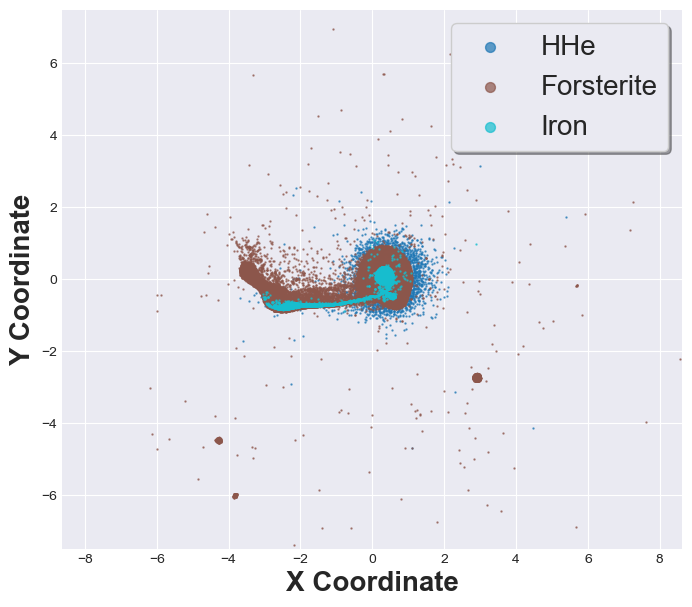

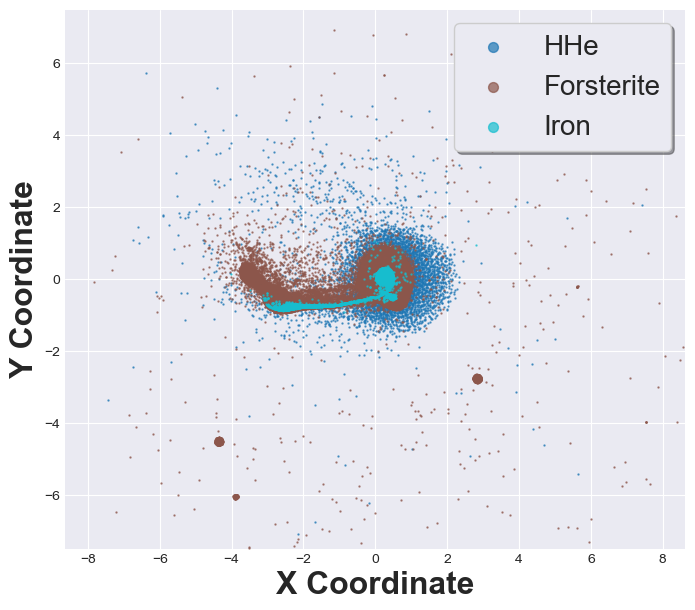

In [3]:
## Function that plots now the graviationally bound particles  

def plot_bound(file, coord, matid, vel, mass, pot, int_en, plot_range, projection="3d"):

    plt.style.use('seaborn-v0_8-darkgrid')

    # Extract the directory and base name of the HDF5 file
    dir = os.path.dirname(file)
    base_name = os.path.splitext(os.path.basename(file))[0]

    plots_folder = os.path.join(dir, "plots")
    os.makedirs(plots_folder, exist_ok=True) 

    # Define the output file path
    output_file = os.path.join(plots_folder, f"{base_name}_bound.png")

    with h5py.File(file, "r") as file:
        coordinates = file[coord][:]
        material_ids = file[matid][:]
        velocities = file[vel][:]
        masses = file[mass][:]
        potentials = file[pot][:]
        internal_energies = file[int_en][:]

        print(f"Loaded {len(coordinates)} particles from {file}")

    # Compute bound particles and filter
    coord_cent, vel_cent, masses, bound_mask = compute_bound_particles(coordinates, velocities, masses, potentials, internal_energies)
    material_ids = material_ids[bound_mask]
    x, y, z = coord_cent[:, 0], coord_cent[:, 1], coord_cent[:, 2]

    print(f"Filtered to {len(coord_cent)} gravitationally bound particles")

    # Define plot range 
    limits = (-plot_range / 2, plot_range / 2)

    # Material IDs and specific colours
    mat_col = {
        200: ("#1f77b4", "HHe"),       # Blue
        400: ("#8c564b", "Forsterite"), # Brown
        401: ("#17becf", "Iron")        # Cyan
    }

    # Plotting code
    fig = plt.figure(figsize=(8, 7))
    if projection == "3d":
        ax = fig.add_subplot(111, projection='3d')
        for material_id, (colour, label) in mat_col.items():
            mask = (material_ids == material_id)
            if np.any(mask):
                ax.scatter(x[mask], y[mask], z[mask], s=1, color=colour, alpha=0.7, label=label)
        ax.set_xlim(limits)
        ax.set_ylim(limits)
        ax.set_zlim(limits)
        ax.set_xlabel("X Coordinate (Centered)")
        ax.set_ylabel("Y Coordinate (Centered)")
        ax.set_zlabel("Z Coordinate (Centered)")
        ax.set_title("3D Bound Particle Positions by Material ID")
        ax.set_box_aspect([1, 1, 1])
    elif projection == "2d":
        ax = fig.add_subplot(111)
        for material_id, (colour, label) in mat_col.items():
            mask = (material_ids == material_id)
            if np.any(mask):
                ax.scatter(x[mask], y[mask], s=0.5, color=colour, alpha=0.7, label=label)
        ax.set_xlim(limits)
        ax.set_ylim(limits)
        ax.set_xlabel("X Coordinate", fontsize=20, fontweight='bold')
        ax.set_ylabel("Y Coordinate", fontsize=20, fontweight='bold')
        # ax.set_title("2D Bound Particle Positions by Material ID", fontsize=22)
        ax.set_aspect('equal', adjustable='datalim')
    else:
        raise ValueError("Invalid projection type. Use '2d' or '3d'.")

    ax.legend(loc="upper right", markerscale=10, fontsize=20, frameon=True, shadow=True)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved as {output_file}")



plot_bound(
        "final_results/b=0.75/n=3/coll2_0005.hdf5",
        "GasParticles/Coordinates",
        "GasParticles/MaterialIDs",
        "GasParticles/Velocities",
        "GasParticles/Masses",
        "GasParticles/Potentials",
        "GasParticles/InternalEnergies",
        plot_range=15,
        projection="2d"
)

init_plot(
        "final_results/b=0.75/n=3/coll2_0005.hdf5",
        "GasParticles/Coordinates",
        "GasParticles/MaterialIDs",
        plot_range=15,
        projection="2d"
    )

Loaded 135504 particles from final_results/b=0.55/n=1/coll1_0901.hdf5
Loaded 135689 particles from final_results/b=0.65/n=1/coll1_0900.hdf5
Loaded 134945 particles from final_results/b=0.75/n=1/coll1_0900.hdf5
Loaded 135591 particles from final_results/b=0.85/n=1/coll1_0900.hdf5
Loaded 147687 particles from final_results/b=0.55/n=2/coll2_0451.hdf5
Loaded 147800 particles from final_results/b=0.65/n=2/coll2_0450.hdf5
Loaded 146994 particles from final_results/b=0.75/n=2/coll2_0450.hdf5
Loaded 147637 particles from final_results/b=0.85/n=2/coll2_0450.hdf5
Loaded 161073 particles from final_results/b=0.55/n=3/coll3_0300.hdf5
Loaded 161108 particles from final_results/b=0.65/n=3/coll3_0300.hdf5
Loaded 161208 particles from final_results/b=0.75/n=3/coll3_0300.hdf5
Loaded 160051 particles from final_results/b=0.85/n=3/coll3_0300.hdf5
Loaded 172068 particles from final_results/b=0.55/n=4/coll4_0226.hdf5
Loaded 172087 particles from final_results/b=0.65/n=4/coll4_0225.hdf5
Loaded 171641 partic

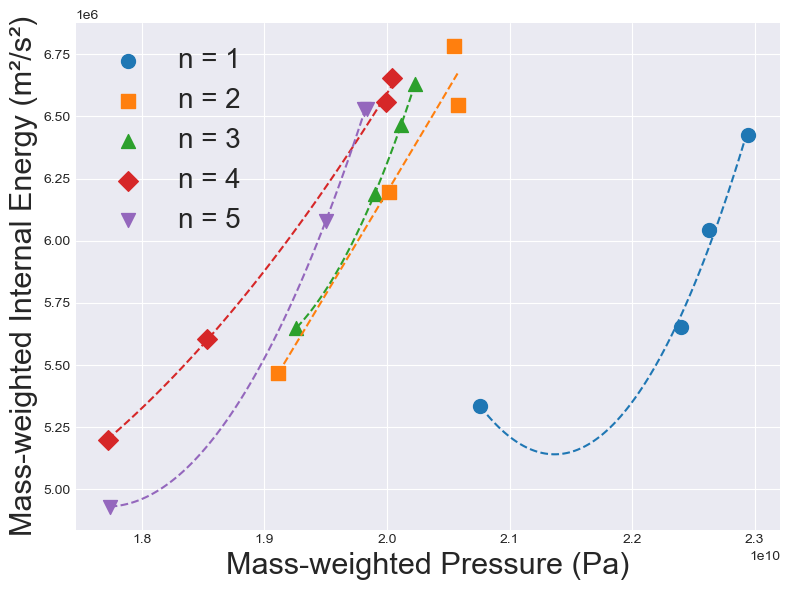

In [4]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt


## Section to convert simulation units (Earth mass and radius) to SI units

# Conversion factors
EARTH_MASS = 5.972e24    # in kg
EARTH_RADIUS = 6.371e6   # in m

# To convert to SI (Pa = kg/(m*s^2)), must multiply by (EARTH_MASS / EARTH_RADIUS)
PRESSURE_CONV_FACTOR= EARTH_MASS / EARTH_RADIUS

# To convert to SI (m^2/s^2),  must multiply by (EARTH_RADIUS**2)
INT_ENERGY_CONV_FACTOR = EARTH_RADIUS**2

## Function that determines the mass weighted pressures and specific internal energies of an hdf5 file

def thermo(file, 
                                      coord,
                                      press,
                                      int_en,
                                      mass,
                                      vel,
                                      pot):
    
    with h5py.File(file, "r") as f:
        coordinates = f[coord][:]
        pressures = f[press][:]
        internal_energies = f[int_en][:]
        masses = f[mass][:]
        velocities = f[vel][:]
        potentials = f[pot][:]
    

    # Print statement to check files loaded correctly
    print(f"Loaded {len(coordinates)} particles from {file}")

    # Get bound particles using compute_bound_particles function
    coord_cent, vel_cent, bound_masses, bound_mask = compute_bound_particles(coordinates, velocities, masses, potentials, internal_energies)
    
    bound_pressures = pressures[bound_mask]
    bound_internal_energies = internal_energies[bound_mask]
    bound_masses = masses[bound_mask]
    
    # Compute mass-weighted averages in simulation units
    avg_press_sim = np.sum(bound_masses * bound_pressures) / np.sum(bound_masses)
    avg_internal_energy_sim = np.sum(bound_masses * bound_internal_energies) / np.sum(bound_masses)
    
    # Convert to SI units using conversion factors
    av_press_SI = avg_press_sim * PRESSURE_CONV_FACTOR
    av_internal_energy_SI = avg_internal_energy_sim * INT_ENERGY_CONV_FACTOR
    
    return av_press_SI, av_internal_energy_SI


# Files sorted by collision number
coll_files = {
    1: [
        "final_results/b=0.55/n=1/coll1_0901.hdf5",
        "final_results/b=0.65/n=1/coll1_0900.hdf5",
        "final_results/b=0.75/n=1/coll1_0900.hdf5",
        "final_results/b=0.85/n=1/coll1_0900.hdf5",
    ],
    2: [
        "final_results/b=0.55/n=2/coll2_0451.hdf5",
        "final_results/b=0.65/n=2/coll2_0450.hdf5",
        "final_results/b=0.75/n=2/coll2_0450.hdf5",
        "final_results/b=0.85/n=2/coll2_0450.hdf5",
    ],
    3: [
        "final_results/b=0.55/n=3/coll3_0300.hdf5",
        "final_results/b=0.65/n=3/coll3_0300.hdf5",
        "final_results/b=0.75/n=3/coll3_0300.hdf5",
        "final_results/b=0.85/n=3/coll3_0300.hdf5",
    ],
    4: [
        "final_results/b=0.55/n=4/coll4_0226.hdf5",
        "final_results/b=0.65/n=4/coll4_0225.hdf5",
        "final_results/b=0.75/n=4/coll4_0225.hdf5",
        "final_results/b=0.85/n=4/coll4_0226.hdf5",
    ],
    5: [
        "final_results/b=0.55/n=5/coll5_0180.hdf5",
        "final_results/b=0.65/n=5/coll5_0180.hdf5",
        "final_results/b=0.75/n=5/coll5_0180.hdf5",
        "final_results/b=0.85/n=5/coll5_0180.hdf5",
    ]
}

# Define markers and colours for each collision number
markers = {1:'o', 2:'s', 3:'^', 4:'D', 5:'v'}
colours = {1:'tab:blue', 2:'tab:orange', 3:'tab:green', 4:'tab:red', 5:'tab:purple'}

# Containers to store variables
group_pressures = {n: [] for n in range(1, 6)}
group_internal_energies = {n: [] for n in range(1, 6)}

# Process each file and group the metrics by collision number
for n, files in coll_files.items():
    for file in files:
        p, u = thermo(file, 
                      "GasParticles/Coordinates", 
                      "GasParticles/Pressures", 
                      "GasParticles/InternalEnergies", 
                      "GasParticles/Masses", 
                      "GasParticles/Velocities", 
                      "GasParticles/Potentials")
        group_pressures[n].append(p)
        group_internal_energies[n].append(u)

# Plotting code
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))

for n in sorted(group_pressures.keys()):
    pressures = group_pressures[n]
    internal_energies = group_internal_energies[n]
    ax.scatter(pressures, internal_energies, 
               color=colours[n], 
               marker=markers[n], 
               s=100, 
               label=f"n = {n}")
    
      # Fit and plot quadratic (2nd degree polynomial) line of best fit
    if len(pressures) > 2:  # Only fit if there are enough points
        poly_coeffs = np.polyfit(pressures, internal_energies, deg=2)  # Quadratic 
        poly_fit = np.poly1d(poly_coeffs)
        pressure_range = np.linspace(min(pressures), max(pressures), 100)
        best_fit_line = poly_fit(pressure_range)
        
        ax.plot(pressure_range, best_fit_line, color=colours[n], linestyle='--')

# Formatting
ax.set_xlabel("Mass-weighted Pressure (Pa)", fontsize=22)
ax.set_ylabel("Mass-weighted Internal Energy (m²/s²)", fontsize=22)
ax.legend(fontsize=20)
plt.tight_layout()
plt.savefig("thermo.png")
plt.show()


Center of Mass: [50.00000044 50.00000466 50.0000021 ]
Number of particles removed: 388027
Filtered particles saved to target.hdf5
Loaded 123170 particles with material IDs from GasParticles/Coordinates
Plot saved as plots\target.png


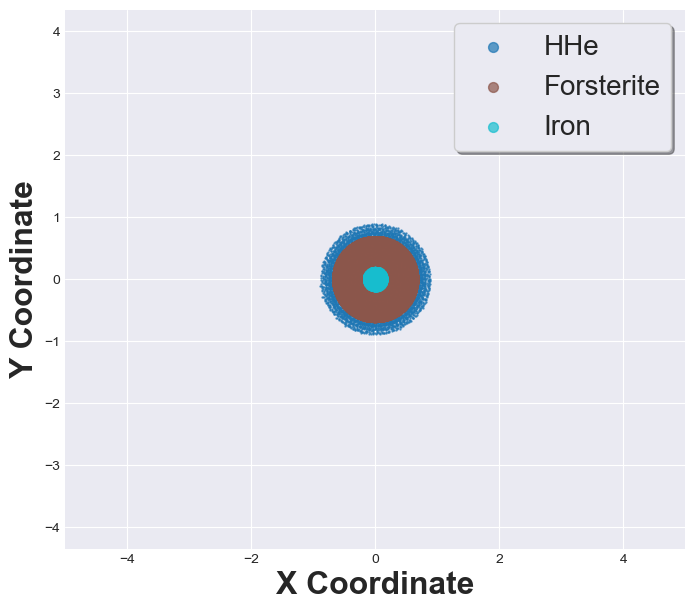

In [5]:
import h5py
import numpy as np

## Function that filters out particles outside a certain radius defined by the user (in Earth radii)

def filter_particles_by_com_distance(input_file, output_file, distance_threshold):
    with h5py.File(input_file, "r") as file:
        
        # Open hdf5 file 
        gas_particles_group = file["GasParticles"]
        coordinates = gas_particles_group["Coordinates"][:]
        masses = gas_particles_group["Masses"][:]
        
        # Calculate center of mass
        total_mass = np.sum(masses)
        com = np.sum(masses[:, None] * coordinates, axis=0) / total_mass
        print(f"Center of Mass: {com}")
        
        # Find distances from COM
        distances = np.linalg.norm(coordinates - com, axis=1)
        
        # Create a mask for particles within the threshold
        within_threshold = distances <= distance_threshold
        num_particles_removed = np.sum(~within_threshold)
        print(f"Number of particles removed: {num_particles_removed}")
        
        # Copy the filtered data to a new HDF5 file
        with h5py.File(output_file, "w") as output:
            # Replicate the structure of the input file
            def copy_and_filter_group(src_group, dst_group, within_threshold):
                for name, item in src_group.items():
                    if isinstance(item, h5py.Group):
                        new_group = dst_group.create_group(name)
                        for attr_name, attr_value in item.attrs.items():
                            new_group.attrs[attr_name] = attr_value
                        copy_and_filter_group(item, new_group, within_threshold)  # Pass within_threshold
                    elif isinstance(item, h5py.Dataset):
                        if len(item.shape) > 0 and item.shape[0] == len(within_threshold):
                            # Ensure within_threshold is a boolean array
                            filtered_data = np.array(item)[within_threshold.astype(bool)]
                            dst_group.create_dataset(name, data=filtered_data)
                        else:
                            dst_group.create_dataset(name, data=item[:])  # Copy datasets without filtering
                        # Copy attributes
                        for attr_name, attr_value in item.attrs.items():
                            dst_group[name].attrs[attr_name] = attr_value

            
            copy_and_filter_group(file, output, within_threshold)

    print(f"Filtered particles saved to {output_file}")
filter_particles_by_com_distance("target_0009.hdf5", "target.hdf5",0.9)


# Target now has a more appropriate atmosphere size
init_plot(
        "target.hdf5",
        "GasParticles/Coordinates",
        "GasParticles/MaterialIDs",
        plot_range=10,
        projection="2d"
    )


Processed final_results/b=0.65/n=1/coll1_0000.hdf5: L = 5.26e-01
Processed final_results/b=0.65/n=1/coll1_0001.hdf5: L = 5.26e-01
Processed final_results/b=0.65/n=1/coll1_0002.hdf5: L = 5.26e-01
Processed final_results/b=0.65/n=1/coll1_0003.hdf5: L = 5.25e-01
Processed final_results/b=0.65/n=1/coll1_0004.hdf5: L = 5.25e-01
Processed final_results/b=0.65/n=1/coll1_0005.hdf5: L = 5.24e-01
Processed final_results/b=0.65/n=1/coll1_0006.hdf5: L = 5.23e-01
Processed final_results/b=0.65/n=1/coll1_0007.hdf5: L = 5.23e-01
Processed final_results/b=0.65/n=1/coll1_0008.hdf5: L = 5.23e-01
Processed final_results/b=0.65/n=1/coll1_0009.hdf5: L = 5.22e-01
Processed final_results/b=0.65/n=1/coll1_0010.hdf5: L = 5.21e-01
Processed final_results/b=0.65/n=1/coll1_0011.hdf5: L = 5.18e-01
Processed final_results/b=0.65/n=1/coll1_0012.hdf5: L = 5.13e-01
Processed final_results/b=0.65/n=1/coll1_0013.hdf5: L = 5.10e-01
Processed final_results/b=0.65/n=1/coll1_0014.hdf5: L = 5.07e-01
Processed final_results/b

KeyboardInterrupt: 

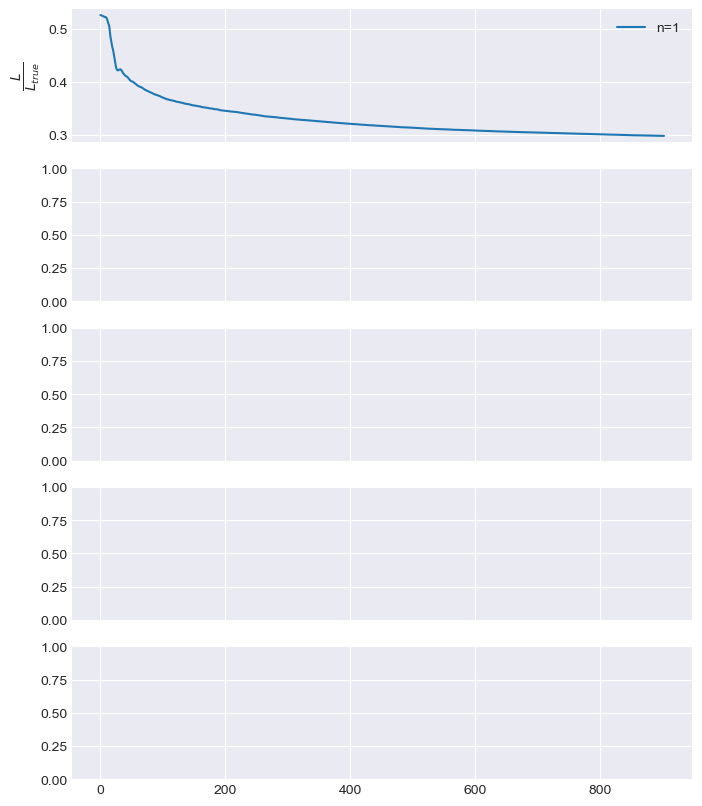

In [6]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Define the true angular momentum of current Earth-Moon system

TRUE_ANGULAR_MOMENTUM = 1.192e-4  # in kg m²/s

## Function that finds the total angular momentum of the system

def find_L(file, 
                                       coord,
                                       vel,
                                       mass,
                                       pot,
                                       int_en):
    with h5py.File(file, "r") as file:
        coordinates = file[coord][:]
        velocities = file[vel][:]
        masses = file[mass][:]
        potentials = file[pot][:]
        internal_energies = file[int_en][:]

    # Call compute_bound_particles function to filter out unbound particles
    coord_cent, vel_cent, bound_masses, bound_mask = compute_bound_particles(coordinates, velocities, masses, potentials, internal_energies)

    # Calculate angular momentum
    L_vector = np.sum(np.cross(coord_cent, vel_cent) * bound_masses[:, None], axis=0)
    # Normalise by the true value of L
    L_magnitude = np.linalg.norm(L_vector)/TRUE_ANGULAR_MOMENTUM 

    return L_magnitude

## Function that plots the angular momentum for each frame in a specific folder - corresponding to a specific simulation

def plot_L(ax, directory, 
                                       coord, 
                                       vel, 
                                       mass, 
                                       pot, 
                                       int_en,
                                       label=None):
    hdf5_files = sorted([f for f in os.listdir(directory) if f.endswith(".hdf5")])
    file_paths = [os.path.join(directory, f) for f in hdf5_files]
    L_magnitudes = []

    for file_path in file_paths:
        L = find_L(file_path, 
                                               coord, 
                                               vel, 
                                               mass, 
                                               pot, 
                                               int_en)
        L_magnitudes.append(L)
        print(f"Processed {file_path}: L = {L:.2e}")

    ax.plot(range(len(L_magnitudes)), L_magnitudes, linestyle="-", label=label if label else directory)
    ax.set_ylabel(r"$\frac{L}{L_{true}}$", fontsize=14)
    ax.legend()
    ax.grid(True)

directories = [
    "final_results/b=0.65/n=1/",
    "final_results/b=0.65/n=2/",
    "final_results/b=0.65/n=3/",
    "final_results/b=0.65/n=4/",
    "final_results/b=0.65/n=5/"
]
labels = ["n=1", "n=2", "n=3", "n=4", "n=5"]

fig, axes = plt.subplots(len(directories), 1, figsize=(8, 10), sharex=True)

for ax, directory, label in zip(axes, directories, labels):
    plot_L(ax, directory, 
                                       "GasParticles/Coordinates", 
                                       "GasParticles/Velocities",
                                       "GasParticles/Masses",
                                       "GasParticles/Potentials",
                                       "GasParticles/InternalEnergies",
                                       label=label)

axes[-1].set_xlabel("Snapshot Index", fontsize=14)
plt.tight_layout()
plt.savefig('L.png')
plt.show()






Loaded 173158 particles from final_results/b=0.85/n=5/coll5_0180.hdf5
Orbiting mass ratio: 0.0618
Angular frequency (spin) of orbiting material: 0.0000 rad/s
Material percentages in the orbiting frame:
HHe: 0.06%
Forsterite: 62.01%
Iron: 37.93%
Plot saved as final_results/b=0.85/n=5\plots\coll5_0180_bound_orbiting.png


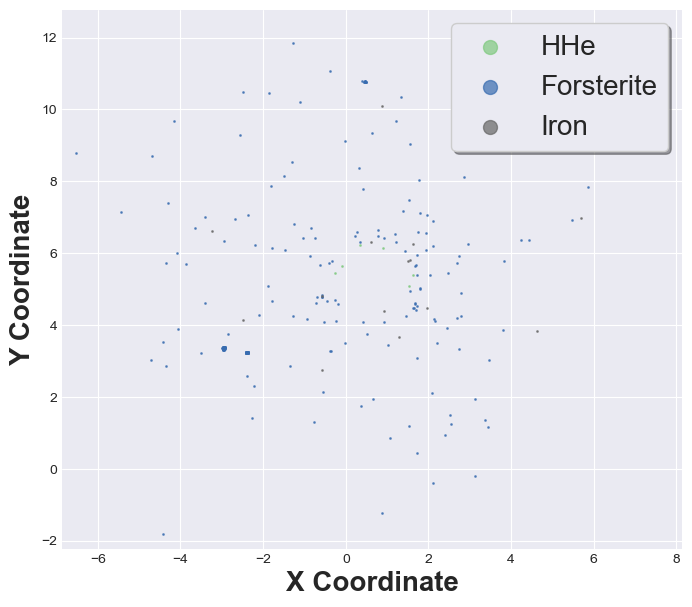

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

## Function which filters only gravitationally bound paritcles, sorts between the central body and orbiting material (as defined by the user), determines the mass percentages and angular frequency, and plots the results

def plot_orbiting(file, 
                                 coord, 
                                 matid, 
                                 vel, 
                                 mass, 
                                 pot, 
                                 int_en, 
                                 plot_range, 
                                 distance_threshold, 
                                 projection, 
                                 filter_type):
    
    plt.style.use('seaborn-v0_8-darkgrid')

    # Material names for labeling
    material_names = {200: "HHe", 400: "Forsterite", 401: "Iron"}

    # Ensure plots directory exists
    dir_name = os.path.dirname(file)
    base_name = os.path.splitext(os.path.basename(file))[0]
    plots_folder = os.path.join(dir_name, "plots")
    os.makedirs(plots_folder, exist_ok=True)
    output_file = os.path.join(plots_folder, f"{base_name}_bound_{filter_type}.png")

    # Load HDF5 data
    with h5py.File(file, "r") as hdf5_file:
        coordinates = hdf5_file[coord][:]
        material_ids = hdf5_file[matid][:]
        velocities = hdf5_file[vel][:]
        masses = hdf5_file[mass][:]
        potentials = hdf5_file[pot][:]
        internal_energies = hdf5_file[int_en][:]
        print(f"Loaded {len(coordinates)} particles from {file}")

    # Compute bound particles
    coord_cent, vel_cent, masses_bound, bound_mask = compute_bound_particles(
        coordinates, velocities, masses, potentials, internal_energies
    )
    
    # Mask material ids
    material_ids_bound = material_ids[bound_mask]
    potentials_bound = potentials[bound_mask]

    # Find the central particle from cnetral potential
    central_index_bound = np.argmin(potentials_bound)
    central_particle = coord_cent[central_index_bound]
    distances = np.linalg.norm(coord_cent - central_particle, axis=1)

    # Apply filter based on distance (orbiting or central body)
    if filter_type == "orbiting":
        filtered_mask = distances > distance_threshold
    elif filter_type == "central":
        filtered_mask = distances <= distance_threshold
    else:
        raise ValueError("Invalid filter_type. Use 'orbiting' or 'central'.")

    # Apply mask to filter data
    filtered_coords = coord_cent[filtered_mask]
    filtered_material_ids = material_ids_bound[filtered_mask]
    filtered_velocities = vel_cent[filtered_mask]
    filtered_masses = masses_bound[filtered_mask]

    # Compute mass ratio
    filtered_mass = np.sum(filtered_masses)
    total_bound_mass = np.sum(masses_bound)
    mass_ratio = filtered_mass / total_bound_mass
    print(f"{filter_type.capitalize()} mass ratio: {mass_ratio:.4f}")

    # Compute angular frequency
    relative_positions = filtered_coords - central_particle
    angular_momentum = np.sum(np.cross(relative_positions, filtered_velocities) * filtered_masses[:, None], axis=0)
    
    # Compute the moment of inertia tensor
    I_tensor = np.zeros((3, 3))
    for r, m in zip(relative_positions, filtered_masses):
        r_outer = np.outer(r, r)
        I_tensor += m * (np.linalg.norm(r) ** 2 * np.identity(3) - r_outer)
    
    omega = np.linalg.solve(I_tensor, angular_momentum)
    angular_frequency = np.linalg.norm(omega)
    print(f"Angular frequency (spin) of {filter_type} material: {angular_frequency:.4f} rad/s")

    # Compute material percentages
    material_percentages = {mid: (np.sum(filtered_masses[filtered_material_ids == mid]) / np.sum(filtered_masses)) * 100 
                            for mid in np.unique(filtered_material_ids)}

    print(f"Material percentages in the {filter_type} frame:")
    for mid, perc in material_percentages.items():
        print(f"{material_names.get(mid, f'Material {mid}')}: {perc:.2f}%")

    # Define limits of plot
    xlim = (central_particle[0] - plot_range/2, central_particle[0] + plot_range/2)
    ylim = (central_particle[1] - plot_range/2, central_particle[1] + plot_range/2)

    # Plot particles
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection='3d' if projection == "3d" else None)

    # Assign colours to materials
    colours = plt.cm.Accent(np.linspace(0, 1, len(material_percentages)))
    mat_col = {mid: colours[i] for i, mid in enumerate(material_percentages.keys())}

    # Scatter plot for each material
    for mid in material_percentages.keys():
        mask = filtered_material_ids == mid
        label = material_names.get(mid, f"Material {mid}")
        if projection == "3d":
            ax.scatter(
                filtered_coords[mask, 0], 
                filtered_coords[mask, 1], 
                filtered_coords[mask, 2],  # Only use this if 3D
                s=1, color=mat_col[mid], alpha=0.7, label=label
            )
        else:  # 2D Plot
            ax.scatter(
                filtered_coords[mask, 0], 
                filtered_coords[mask, 1], 
                s=1, color=mat_col[mid], alpha=0.7, label=label
            )

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if projection == "3d":
        ax.set_zlabel("Z Coordinate (Centered)")
    
    ax.set_xlabel("X Coordinate", fontsize=20, fontweight='bold')
    ax.set_ylabel("Y Coordinate", fontsize=20, fontweight='bold')

    ax.legend(loc="upper right", markerscale=10, fontsize=20, frameon=True, shadow=True)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved as {output_file}")
    plt.show()

plot_orbiting("final_results/b=0.85/n=5/coll5_0180.hdf5",
                             "GasParticles/Coordinates",
                             "GasParticles/MaterialIDs",
                             "GasParticles/Velocities",
                             "GasParticles/Masses",
                             "GasParticles/Potentials",
                             "GasParticles/InternalEnergies",
                             plot_range=15,
                             distance_threshold=1, # In R_earth - adjust manually
                             projection="2d",
                             filter_type="orbiting" # Use 'orbiting' or 'central'
                             )


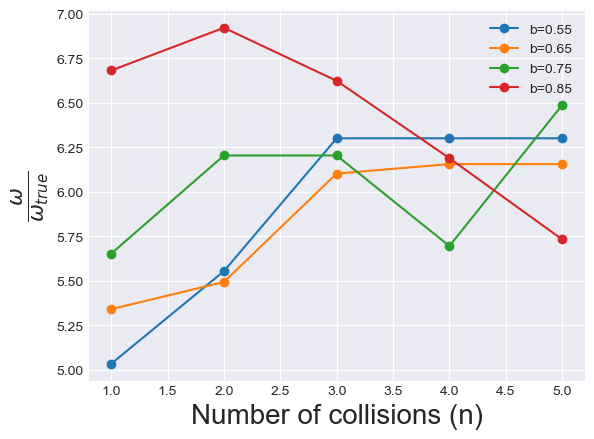

In [41]:
## Plot which shows number angular frequencies of the central body for each simulation

b55 = [0.00036714785522978154 , 0.00040509098394409524, 0.00045952333700916047, 0.00045952333700916047, 0.00045952333700916047]
b65 = [0.0003894951928519674, 0.00040067244901083744, 0.000445064026168974, 0.00044893939616635653, 0.00044893939616635653]
b75 = [0.0004122745631490556, 0.0004524833639572655, 0.0004524833639572655, 0.0004153677462175809, 0.0004731254235433756]
b85 = [0.00048730040822224043, 0.0005047874533434058, 0.00048305754533635296, 0.00045137350724584204, 0.0004181100255920696]
n = [1, 2, 3, 4, 5]
true_val = 0.000072921159

plt.xlabel("Number of collisions (n)", fontsize=20)
plt.ylabel(r"$\frac{\omega}{\omega_{true}}$", fontsize=22)
plt.plot(n, np.array(b55)/true_val, marker='o', linestyle='-', label='b=0.55')
plt.plot(n, np.array(b65)/true_val, marker='o', linestyle='-', label='b=0.65')
plt.plot(n, np.array(b75)/true_val, marker='o', linestyle='-', label='b=0.75')
plt.plot(n, np.array(b85)/true_val, marker='o', linestyle='-', label='b=0.85')

plt.legend(loc='upper right', fontsize=10)
plt.savefig('spin.png')

Loaded 171119 particles from final_results/b=0.85/n=4/coll4_0226.hdf5
Orbiting mass ratio: 0.0807
Angular frequency (spin) of orbiting material: 0.0000 rad/s
Material percentages in the orbiting frame:
Forsterite (Impactor): 60.34%
Forsterite (Target): 3.30%
HHe: 0.07%
Iron (Impactor): 33.99%
Iron (Target): 2.30%
Plot saved as final_results/b=0.85/n=4\plots\coll4_0226_bound_orbiting.png


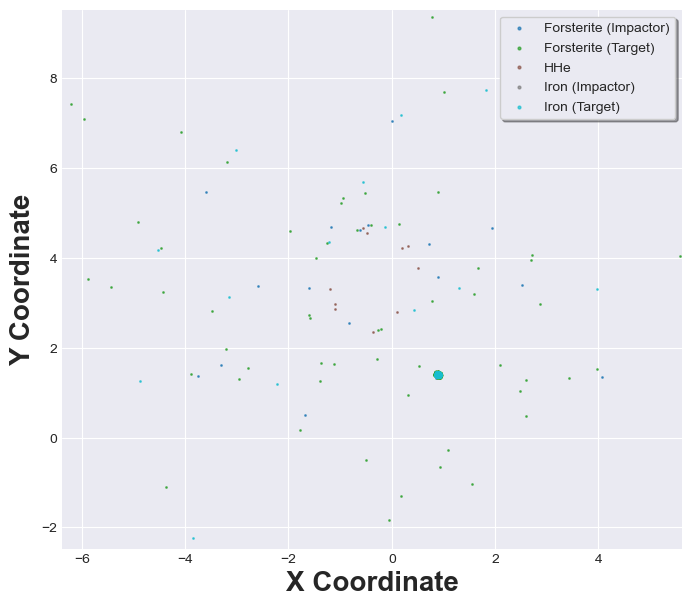

In [8]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

## Updated version of previous plotting function, which now also differentiates between the origin of each particle

def plot_orbiting_by_origin(file, 
                            coord, 
                            pid, 
                            matid, 
                            vel, 
                            mass, 
                            pot, 
                            int_en, 
                            plot_range, 
                            distance_threshold, 
                            projection, 
                            filter_type):
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Define material names for labeling
    material_names = {200: "HHe", 400: "Forsterite", 401: "Iron"}

    # Ensure figure is saved in a "plots" folder next to the file
    dir_name = os.path.dirname(file)
    base_name = os.path.splitext(os.path.basename(file))[0]
    plots_folder = os.path.join(dir_name, "plots")
    os.makedirs(plots_folder, exist_ok=True)
    output_file = os.path.join(plots_folder, f"{base_name}_bound_{filter_type}.png")
    
    # Extract data from the HDF5 file
    with h5py.File(file, "r") as f:
        coordinates = f[coord][:]
        particle_ids = f[pid][:]
        material_ids = f[matid][:]
        velocities = f[vel][:]
        masses = f[mass][:]
        potentials = f[pot][:]
        internal_energies = f[int_en][:]
        print(f"Loaded {len(coordinates)} particles from {file}")
    
    # Compute gravitationally bound particles
    coord_cent, vel_cent, masses_bound, bound_mask = compute_bound_particles(
        coordinates, velocities, masses, potentials, internal_energies
    )
    # Also filter particle and material IDs
    particle_ids_bound = particle_ids[bound_mask]
    material_ids_bound = material_ids[bound_mask]
    potentials_bound = potentials[bound_mask]
    
    # Define the central particle as the one with the minimum potential
    central_index_bound = np.argmin(potentials_bound)
    central_particle = coord_cent[central_index_bound]
    # Compute distances from the central particle
    distances = np.linalg.norm(coord_cent - central_particle, axis=1)
    
    # Filter based on the distance threshold
    if filter_type == "orbiting":
        filtered_mask = distances > distance_threshold
    elif filter_type == "central":
        filtered_mask = distances <= distance_threshold
    else:
        raise ValueError("Invalid filter_type. Use 'orbiting' or 'central'.")
    
    # Apply the filtered mask to the bound arrays
    filtered_coords = coord_cent[filtered_mask]
    filtered_material_ids = material_ids_bound[filtered_mask]
    filtered_velocities = vel_cent[filtered_mask]
    filtered_masses = masses_bound[filtered_mask]
    filtered_particle_ids = particle_ids_bound[filtered_mask]
    
    # Compute the mass ratio of the filtered particles to the total bound mass
    filtered_mass = np.sum(filtered_masses)
    total_bound_mass = np.sum(masses_bound)
    mass_ratio = filtered_mass / total_bound_mass
    print(f"{filter_type.capitalize()} mass ratio: {mass_ratio:.4f}")
    
    # Compute angular frequency (spin)
    relative_positions = filtered_coords - central_particle
    angular_momentum = np.sum(np.cross(relative_positions, filtered_velocities) * filtered_masses[:, None], axis=0)
    
    I_tensor = np.zeros((3, 3))
    for r, m in zip(relative_positions, filtered_masses):
        r_outer = np.outer(r, r)
        I_tensor += m * (np.linalg.norm(r)**2 * np.identity(3) - r_outer)
    
    # Solve I_tensor * omega = angular_momentum
    omega = np.linalg.solve(I_tensor, angular_momentum)
    angular_frequency = np.linalg.norm(omega)
    print(f"Angular frequency (spin) of {filter_type} material: {angular_frequency:.4f} rad/s")
    
    # Label each particle by origin (using particle IDs and material IDs)
    composite_labels = []
    for mid, pid in zip(filtered_material_ids, filtered_particle_ids):
        if mid == 200:
            composite_labels.append("HHe")
        elif mid == 400:
            if pid < 123170:
                composite_labels.append("Forsterite (Target)")
            else:
                composite_labels.append("Forsterite (Impactor)")
        elif mid == 401:
            if pid < 123170:
                composite_labels.append("Iron (Target)")
            else:
                composite_labels.append("Iron (Impactor)")
        else:
            composite_labels.append(f"Material {mid}")
    composite_labels = np.array(composite_labels)
    
    # Compute material percentages
    material_percentages = {}
    unique_labels = np.unique(composite_labels)
    for label in unique_labels:
        mask = composite_labels == label
        material_mass = np.sum(filtered_masses[mask])
        percentage = (material_mass / filtered_mass) * 100
        material_percentages[label] = percentage
    
    print(f"Material percentages in the {filter_type} frame:")
    for label, perc in material_percentages.items():
        print(f"{label}: {perc:.2f}%")
    
    # Define plot limits centered on the central particle
    xlim = (central_particle[0] - plot_range/2, central_particle[0] + plot_range/2)
    ylim = (central_particle[1] - plot_range/2, central_particle[1] + plot_range/2)
    
    # Create the plot
    fig = plt.figure(figsize=(8, 7))
    if projection == "3d":
        ax = fig.add_subplot(111, projection='3d')
        colours = plt.cm.Accent(np.linspace(0, 1, len(unique_labels)))
        label_colours = {label: colours[i] for i, label in enumerate(unique_labels)}
        for label in unique_labels:
            mask = composite_labels == label
            ax.scatter(filtered_coords[mask, 0],
                       filtered_coords[mask, 1],
                       filtered_coords[mask, 2],
                       s=1, color=label_colours[label],
                       alpha=0.7, label=label)
        ax.set_zlabel("Z Coordinate (Centered)")
    elif projection == "2d":
        ax = fig.add_subplot(111)
        colours = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
        label_colours = {label: colours[i] for i, label in enumerate(unique_labels)}
        for label in unique_labels:
            mask = composite_labels == label
            ax.scatter(filtered_coords[mask, 0],
                       filtered_coords[mask, 1],
                       s=1, color=label_colours[label],
                       alpha=0.7, label=label)
        ax.set_xlabel("X Coordinate", fontsize=20, fontweight='bold')
        ax.set_ylabel("Y Coordinate", fontsize=20, fontweight='bold')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc="upper right", markerscale=2, fontsize=10, frameon=True, shadow=True)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved as {output_file}")
    plt.show()

# Example Usage:
plot_orbiting_by_origin(
    "final_results/b=0.85/n=4/coll4_0226.hdf5",
    "GasParticles/Coordinates",
    "GasParticles/ParticleIDs",
    "GasParticles/MaterialIDs",
    "GasParticles/Velocities",
    "GasParticles/Masses",
    "GasParticles/Potentials",
    "GasParticles/InternalEnergies",
    plot_range=12,
    distance_threshold=1,  # In Earth radii (R_earth) – adjust as needed
    projection="2d",
    filter_type="orbiting"  # Use 'orbiting' or 'central'
)


In [10]:
import os
import re
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # for progress bar


## Function that plots the time evolution of mass composition over the course of a simulation

def plot_time_evolution_mass_percentages(folder, 
                                         coord,
                                         pid, 
                                         matid,
                                         vel,
                                         mass,
                                         pot,
                                         int_en,
                                         distance_threshold,
                                         filter_type):
    # Define composite keys and corresponding colour scheme.
    composite_keys = ["HHe", "Forsterite (Target)", "Forsterite (Impactor)", "Iron (Target)", "Iron (Impactor)"]
    colours = {
        "Forsterite (Target)": "#8c564b",
        "Forsterite (Impactor)": "#d62728",
        "HHe": "#1f77b4",
        "Iron (Target)": "#17becf",
        "Iron (Impactor)": "#a9a9a9"
    }
    
    # Prepare a dictionary to store the mass percentages.
    percentages_by_label = {key: [] for key in composite_keys}
    
    # Get a sorted list of all HDF5 files in the folder.
    file_list = sorted([f for f in os.listdir(folder) if f.endswith('.hdf5')])
    
    # Process each file with a progress bar.
    for filename in tqdm(file_list, desc="Processing HDF5 files"):
        file_path = os.path.join(folder, filename)
        
        # Load data from the HDF5 file.
        with h5py.File(file_path, "r") as f:
            coordinates = f[coord][:]
            particle_ids = f[pid][:]
            material_ids = f[matid][:]
            velocities = f[vel][:]
            masses = f[mass][:]
            potentials = f[pot][:]
            internal_energies = f[int_en][:]
        
       
        
        # Compute gravitationally bound particles.
        coord_cent, _, masses_bound, bound_mask = compute_bound_particles(coordinates, velocities, masses, potentials, internal_energies)
        particle_ids_bound = particle_ids[bound_mask]
        material_ids_bound = material_ids[bound_mask]
        
        # Identify the central particle (with minimum potential among bound particles)
        potentials_bound = potentials[bound_mask]
        central_index_bound = np.argmin(potentials_bound)
        central_particle = coord_cent[central_index_bound]
        distances = np.linalg.norm(coord_cent - central_particle, axis=1)
        
        # Filter between orbiting and central material.
        if filter_type == "orbiting":
            filtered_mask = distances > distance_threshold
        elif filter_type == "central":
            filtered_mask = distances <= distance_threshold
        else:
            raise ValueError("Invalid filter_type. Use 'orbiting' or 'central'.")
        
        # Apply the filter.
        filtered_coords = coord_cent[filtered_mask]
        filtered_particle_ids = particle_ids_bound[filtered_mask]
        filtered_material_ids = material_ids_bound[filtered_mask]
        filtered_masses = masses_bound[filtered_mask]
        
        # Total mass of the filtered selection.
        filtered_mass_total = np.sum(filtered_masses)
        
        # Compute composite labels based on material IDs and particle IDs.
        composite_labels = []
        for mid, pid in zip(filtered_material_ids, filtered_particle_ids):
            if mid == 200:
                composite_labels.append("HHe")
            elif mid == 400:
                if pid < 123170:
                    composite_labels.append("Forsterite (Target)")
                else:
                    composite_labels.append("Forsterite (Impactor)")
            elif mid == 401:
                if pid < 123170:
                    composite_labels.append("Iron (Target)")
                else:
                    composite_labels.append("Iron (Impactor)")
            else:
                composite_labels.append(f"Material {mid}")
        composite_labels = np.array(composite_labels)
        
        # Compute mass percentages for each composite label.
        percentages_this_file = {key: 0.0 for key in composite_keys}
        for key in composite_keys:
            mask = composite_labels == key
            if np.sum(mask) > 0 and filtered_mass_total > 0:
                mass_key = np.sum(filtered_masses[mask])
                percentages_this_file[key] = (mass_key / filtered_mass_total) * 100
        
        # Append computed percentages for each composite label.
        for key in composite_keys:
            percentages_by_label[key].append(percentages_this_file[key])
    
    # Define the x-axis as time points (e.g., from 0 to 900 seconds).
    time_points = np.linspace(0, 900, num=len(file_list))
    
    # Plot the time evolution of the mass percentages.
    plt.figure(figsize=(10, 6))
    for key in composite_keys:
        plt.plot(time_points, percentages_by_label[key], marker='o', label=key, markersize=3, color=colours[key])
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Mass Percentage (%)', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('comp_evo.png')
    plt.show()

# Example usage:
plot_time_evolution_mass_percentages("final_results/b=0.75/n=3/",
                             "GasParticles/Coordinates",
                             "GasParticles/ParticleIDs",
                             "GasParticles/MaterialIDs",
                             "GasParticles/Velocities",
                             "GasParticles/Masses",
                             "GasParticles/Potentials",
                             "GasParticles/InternalEnergies",
                             distance_threshold=1,  # In Earth radii – adjust manually
                             filter_type="orbiting"  # Use 'orbiting' or 'central'
)


Processing HDF5 files:   0%|          | 0/903 [00:00<?, ?it/s]

Processing HDF5 files:   0%|          | 1/903 [00:00<03:57,  3.80it/s]


TypeError: Accessing a group is done with bytes or str, not <class 'numpy.uint64'>

AttributeError: Rectangle.set() got an unexpected keyword argument 'colour'

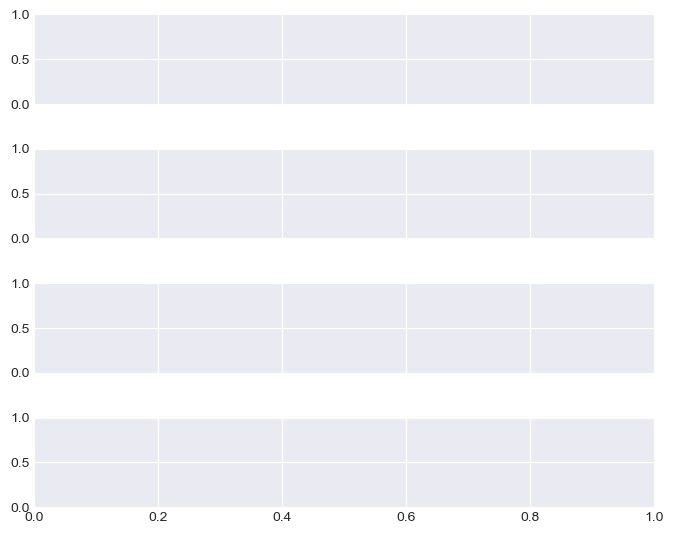

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import math

## Code to plot the compositions of each simulations orbiting material

data = {
    "b0.55n1": {
        "Forsterite (Target)": 12.31, 
        "Forsterite (Impactor)": 22.37, 
        "HHe": 65.28, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.55n2": {
        "Forsterite (Target)": 18.42, 
        "Forsterite (Impactor)": 47.38, 
        "HHe": 19.48, 
        "Iron (Target)": 12.86, 
        "Iron (Impactor)": 1.86
    },
    "b0.55n3": {
        "Forsterite (Target)": 49.06, 
        "Forsterite (Impactor)": 46.52, 
        "HHe": 4.42, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.55n4": {
        "Forsterite (Target)": 42.56, 
        "Forsterite (Impactor)": 37.62, 
        "HHe": 11.27, 
        "Iron (Target)": 3.42, 
        "Iron (Impactor)": 5.13
    },
    "b0.55n5": {
        "Forsterite (Target)": 50.69, 
        "Forsterite (Impactor)": 45.56, 
        "HHe": 2.84, 
        "Iron (Target)": 0.46, 
        "Iron (Impactor)": 0.46
    },
    "b0.65n1": {
        "Forsterite (Target)": 16.14, 
        "Forsterite (Impactor)": 0, 
        "HHe": 83.86, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.65n2": {
        "Forsterite (Target)": 3.33, 
        "Forsterite (Impactor)": 95.04, 
        "HHe": 0.83, 
        "Iron (Target)": 0.42, 
        "Iron (Impactor)": 0.38
    },
    "b0.65n3": {
        "Forsterite (Target)": 5.45, 
        "Forsterite (Impactor)": 94.11, 
        "HHe": 0.44, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.65n4": {
        "Forsterite (Target)": 17.07, 
        "Forsterite (Impactor)": 78.7, 
        "HHe": 0.95, 
        "Iron (Target)": 1.16, 
        "Iron (Impactor)": 2.12
    },
    "b0.65n5": {
        "Forsterite (Target)": 48.13, 
        "Forsterite (Impactor)": 49.66, 
        "HHe": 1.23, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0.99
    },
    "b0.75n1": {
        "Forsterite (Target)": 13.76, 
        "Forsterite (Impactor)": 74.92, 
        "HHe": 10.92, 
        "Iron (Target)": 0.4, 
        "Iron (Impactor)": 0
    },
    "b0.75n2": {
        "Forsterite (Target)": 7.29, 
        "Forsterite (Impactor)": 82.61, 
        "HHe": 1.66, 
        "Iron (Target)": 1.35, 
        "Iron (Impactor)": 7.08
    },
    "b0.75n3": {
        "Forsterite (Target)": 90.79, 
        "Forsterite (Impactor)": 8.47, 
        "HHe": 0.43, 
        "Iron (Target)": 0.05, 
        "Iron (Impactor)": 0.27
    },
    "b0.75n4": {
        "Forsterite (Target)": 11.58, 
        "Forsterite (Impactor)": 51.98, 
        "HHe": 0.29, 
        "Iron (Target)": 0.2, 
        "Iron (Impactor)": 35.94
    },
    "b0.75n5": {
        "Forsterite (Target)": 30.04, 
        "Forsterite (Impactor)": 49.27, 
        "HHe": 0.55, 
        "Iron (Target)": 0.84, 
        "Iron (Impactor)": 18.91
    },
    "n=1": {
        "Forsterite (Target)": 4.18, 
        "Forsterite (Impactor)": 93.84, 
        "HHe": 1.98, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "n=2": {
        "Forsterite (Target)": 5.58, 
        "Forsterite (Impactor)": 90.18, 
        "HHe": 0.21, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 4.03
    },
    "n=3": {
        "Forsterite (Target)": 29.77, 
        "Forsterite (Impactor)": 36.8, 
        "HHe": 0.25, 
        "Iron (Target)": 0.89,
        "Iron (Impactor)": 32.28
    },
    "n=4": {
        "Forsterite (Target)": 3.34, 
        "Forsterite (Impactor)": 60.27, 
        "HHe": 0.1, 
        "Iron (Target)": 2.33, 
        "Iron (Impactor)": 33.96
    },
    "n=5": {
        "Forsterite (Target)": 9.55, 
        "Forsterite (Impactor)": 52.42, 
        "HHe": 0.17, 
        "Iron (Target)": 0.3, 
        "Iron (Impactor)": 37.56
    },
}
# Convert dictionary into a DataFrame
df = pd.DataFrame(data).T
df.index.name = "Number of collisions"

# Define number of simulations per row for plotting
simulations_per_row = 5
total_simulations = len(df)
rows = math.ceil(total_simulations / simulations_per_row)

# Define colours for the composite materials.
colours = {
    "Forsterite (Target)": "#8c564b",
    "Forsterite (Impactor)": "#d62728",
    "HHe": "#1f77b4",
    "Iron (Target)": "#17becf",
    "Iron (Impactor)": "#a9a9a9"
}



# Create subplots with reduced spacing
fig, axes = plt.subplots(rows, 1, figsize=(8, 1.6 * rows), sharex=True, gridspec_kw={'hspace': 0.5})

# Ensure axes is a list even if only one row exists
if rows == 1:
    axes = [axes]

# Set font sizes
title_fontsize = 22
label_fontsize = 18
tick_fontsize = 14
legend_fontsize = 16

# Plot each group of simulations
for i in range(rows):
    start = i * simulations_per_row
    end = start + simulations_per_row
    subset_df = df.iloc[start:end]

    # Order the DataFrame columns according to the colours dictionary
    ordered_cols = [col for col in colours.keys() if col in subset_df.columns]
    subset_df = subset_df[ordered_cols]

    subset_df.plot(kind='bar', stacked=True, ax=axes[i],
                   colour=[colours[col] for col in ordered_cols], width=0.85)

  
    axes[i].tick_params(axis='x', labelsize=tick_fontsize)
    axes[i].tick_params(axis='y', labelsize=tick_fontsize)

# Set one shared y-axis label for the entire figure.
fig.text(0.04, 0.5, 'Percentage (%)', va='center', rotation='vertical', fontsize=label_fontsize)

# Adjust legend placement for clarity
axes[0].legend(title='Material', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=title_fontsize)

# Rotate x-axis labels on the bottom subplot to 45°.
for label in axes[-1].get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

# Hide legends for all other subplots
for i in range(1, rows):
    axes[i].get_legend().remove()

if rows > 0:
    axes[0].set_title('b = 0.55', fontsize=title_fontsize)
if rows > 1:
    axes[1].set_title('b = 0.65', fontsize=title_fontsize)
if rows > 2:
    axes[2].set_title('b = 0.75', fontsize=title_fontsize)
if rows > 3:
    axes[3].set_title('b = 0.85', fontsize=title_fontsize)


plt.tight_layout()
plt.savefig('config_composite_improved.png', dpi=300)
plt.show()

number of particles: 126288


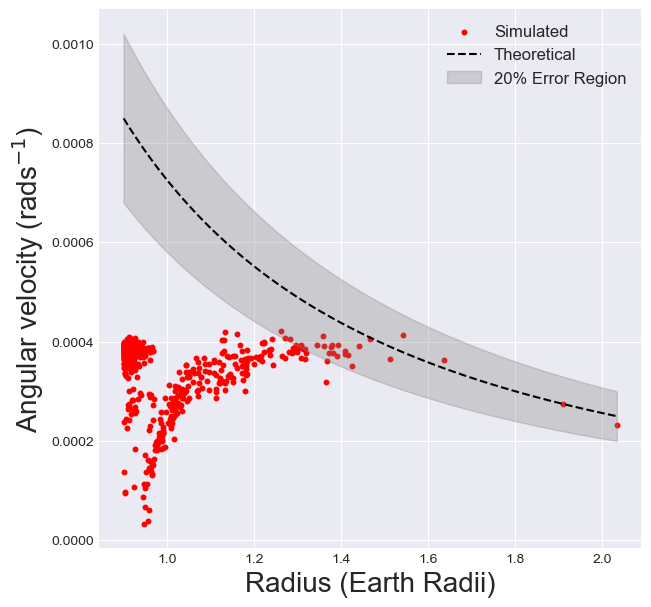

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

## Function that determines the angular velocity of the orbiting material, plots it, and compares it with the theoretical keplerian orbit, within 20%

def keplerian_rotation(file, 
                       coord, 
                       matid, 
                       vel,
                       mass,
                       pot,
                       int_en,
                       distance_threshold,
                       save_path="keplerian_rotation.png"):
 
    plt.style.use('seaborn-v0_8-darkgrid')

    G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
    EARTH_RADIUS_METERS = 6.371e6  # Earth radius in meters
    EARTH_MASS_KG = 5.972e24  # Earth mass in kilograms

    # Load datasets
    with h5py.File(file, "r") as file:
        coordinates = file[coord][:]
        material_ids = file[matid][:]
        velocities = file[vel][:]
        masses = file[mass][:]
        potentials = file[pot][:]
        internal_energies = file[int_en][:]

    # Get bound particles using compute_bound_particles function
    coordinates_bound, velocities_bound, bound_masses, bound_mask = compute_bound_particles(coordinates, velocities, masses, potentials, internal_energies)
    
    
    potentials_bound = potentials[bound_mask]
    masses_bound = masses[bound_mask]

    # Find the central particle (deepest potential well)
    central_index_bound = np.argmin(potentials_bound)
    central_pot = coordinates_bound[central_index_bound]

    # Compute distances from central particle
    displacement_vectors = coordinates_bound - central_pot
    distances = np.linalg.norm(displacement_vectors, axis=1)

    # **Corrected Central Mass Calculation**
    central_mass_kg = np.sum(masses_bound[distances < distance_threshold]) * EARTH_MASS_KG  # Convert to kg

    # Filter orbiting material
    orbiting_mask = distances > distance_threshold
    orbiting_distances = distances[orbiting_mask]
    orbiting_velocities = velocities_bound[orbiting_mask]

    # Compute tangential velocity (true orbital motion)
    radial_unit_vectors = displacement_vectors[orbiting_mask] / orbiting_distances[:, None]  # Normalize
    velocity_components_along_r = np.sum(orbiting_velocities * radial_unit_vectors, axis=1)
    tangential_velocities = orbiting_velocities - (velocity_components_along_r[:, None] * radial_unit_vectors)
    tangential_speeds = np.linalg.norm(tangential_velocities, axis=1)

    # Compute true angular velocity (Omega) from tangential velocity
    omega_simulated = tangential_speeds / orbiting_distances

    # Compute theoretical Keplerian rotation using total mass within threshold
    radii_theoretical = np.linspace(np.min(orbiting_distances), np.max(orbiting_distances), 100)
    
    # Convert to meters correctly
    radii_meters_theoretical = radii_theoretical * EARTH_RADIUS_METERS  

    # Keplerian Formula (with corrected mass)
    omega_theoretical = np.sqrt(G * central_mass_kg / (radii_meters_theoretical**3))

    # Compute 20% error bounds
    omega_upper = 1.2 * omega_theoretical
    omega_lower = 0.8 * omega_theoretical

    # Plot Keplerian rotation
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(orbiting_distances, omega_simulated, color='red', s=5, label="Simulated", lw=2)
    ax.plot(radii_theoretical, omega_theoretical, color='black', linestyle="--", label="Theoretical")
    ax.fill_between(radii_theoretical, omega_lower, omega_upper, color='gray', alpha=0.3, label="20% Error Region")

    ax.set_xlabel("Radius (Earth Radii)", fontsize=20)
    ax.set_ylabel(r"Angular velocity (rads$^{-1}$)", fontsize=20)
    ax.legend(fontsize=12)
    ax.grid(True)
    print(f"number of particles: {len(orbiting_mask)}")

    # Save the plot
    fig.savefig(save_path, bbox_inches='tight')
    plt.show()

b = 0.65
n = 1


keplerian_rotation(f"final_results/b={b}/n={n}/coll{n}_0900.hdf5",
                   "GasParticles/Coordinates",
                   "GasParticles/MaterialIDs",
                   "GasParticles/Velocities",
                   "GasParticles/Masses",
                   "GasParticles/Potentials",
                   "GasParticles/InternalEnergies",
                   distance_threshold=0.9,
                   save_path=f"kep_b={b}_n={n}.png")

Loaded 173158 particles from final_results/b=0.85/n=5/coll5_0180.hdf5
Filtered to 162192 gravitationally bound particles
Central particle found at index 50184 with coordinates: [ 0.64093404  5.27703614 -0.09340519]
Central mass (from particles with distance < 0.9): 1.750e+24 kg
Number of orbiting particles (distance > 0.9): 10302
Number of orbiting particles after Keplerian filtering: 2754
Orbiting mass ratio (filtered orbiting mass / total bound mass): 0.0166
Material percentages in the filtered orbiting frame (by mass):
Forsterite (Impactor): 48.87%
Forsterite (Target): 30.50%
Iron (Impactor): 19.93%
Iron (Target): 0.69%
Plot saved as final_results/b=0.85/n=5\plots\coll5_0180_filtered_orbiting.png


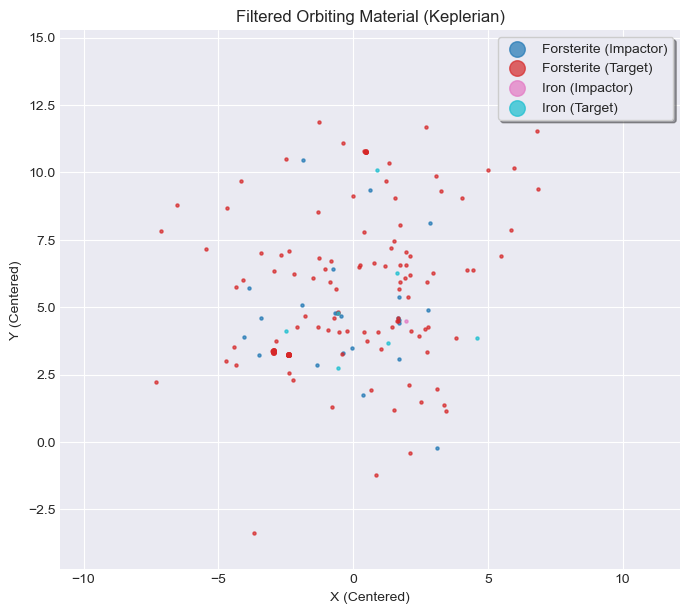

(0.016593663,
 {'Forsterite (Impactor)': 48.87249767780304,
  'Forsterite (Target)': 30.503803491592407,
  'Iron (Impactor)': 19.93355005979538,
  'Iron (Target)': 0.6901441607624292})

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

## Function that combines the keplerian filtering system to the orbiting plot

def plot_keplerian_filtered_bound_orbiting_material(file,
                                                    coord,
                                                    pid,
                                                    matid,
                                                    vel,
                                                    mass,
                                                    pot,
                                                    int_en,
                                                    plot_range,
                                                    distance_threshold,
                                                    projection="2d",
                                                    save_plot=True):

    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Constants 
    G = 6.67430e-11            # m^3 kg^-1 s^-2
    EARTH_RADIUS_METERS = 6.371e6  # m
    EARTH_MASS_KG = 5.972e24       # kg

    # Load datasets from the file.
    with h5py.File(file, "r") as f:
        coordinates = f[coord][:]
        particle_ids = f[pid][:]
        material_ids = f[matid][:]
        velocities = f[vel][:]
        masses = f[mass][:]
        potentials = f[pot][:]
        internal_energies = f[int_en][:]
    
    print(f"Loaded {len(coordinates)} particles from {file}")
    
    # --- Compute COM and filter to bound particles by calling the first function ---
    coord_cent, vel_cent, masses_bound, bound_mask = compute_bound_particles(coordinates, velocities, masses, potentials, internal_energies)
    
    # Filtered particles
    coordinates_bound = coord_cent
    particle_ids_bound = particle_ids[bound_mask]
    material_ids_bound = material_ids[bound_mask]
    velocities_bound = vel_cent
    masses_bound = masses_bound
    potentials_bound = potentials[bound_mask]
    
    
    print(f"Filtered to {len(coordinates_bound)} gravitationally bound particles")
    
    # --- Identify Central Particle ---
    central_index_bound = np.argmin(potentials_bound)
    central_particle = coordinates_bound[central_index_bound]
    print(f"Central particle found at index {central_index_bound} with coordinates: {central_particle}")
    
    # Compute distances of bound particles from the central particle.
    distances = np.linalg.norm(coordinates_bound - central_particle, axis=1)
    
    # Calculate central mass (for Keplerian rotation) from particles within distance_threshold.
    central_mass_kg = np.sum(masses_bound[distances < distance_threshold]) * EARTH_MASS_KG
    print(f"Central mass (from particles with distance < {distance_threshold}): {central_mass_kg:.3e} kg")
    
    # --- Define Orbiting Material ---
    orbiting_mask = distances > distance_threshold
    orbiting_coords = coordinates_bound[orbiting_mask]
    orbiting_particle_ids = particle_ids_bound[orbiting_mask]
    orbiting_material_ids = material_ids_bound[orbiting_mask]
    orbiting_velocities = velocities_bound[orbiting_mask]
    orbiting_masses = masses_bound[orbiting_mask]
    orbiting_distances = distances[orbiting_mask]
    print(f"Number of orbiting particles (distance > {distance_threshold}): {len(orbiting_coords)}")
    
    # --- Compute Angular Velocities ---
    # Compute tangential velocities (projecting out the radial component).
    disp_vectors = orbiting_coords - central_particle
    radial_unit_vectors = disp_vectors / orbiting_distances[:, None]  # Normalize
    radial_components = np.sum(orbiting_velocities * radial_unit_vectors, axis=1)
    tangential_velocities = orbiting_velocities - (radial_components[:, None] * radial_unit_vectors)
    tangential_speeds = np.linalg.norm(tangential_velocities, axis=1)
    
    # Simulated angular velocity.
    omega_simulated = tangential_speeds / orbiting_distances
    
    # Theoretical (Keplerian) angular velocity.
    orbiting_radii_m = orbiting_distances * EARTH_RADIUS_METERS
    omega_theoretical = np.sqrt(G * central_mass_kg / (orbiting_radii_m**3))
    
    # Define ±20% error bounds
    omega_lower = 0.8 * omega_theoretical
    omega_upper = 1.2 * omega_theoretical
    
    # Filter orbiting particles based on Keplerian criteria.
    keplerian_mask = (omega_simulated >= omega_lower) & (omega_simulated <= omega_upper)
    filtered_coords = orbiting_coords[keplerian_mask]
    filtered_particle_ids = orbiting_particle_ids[keplerian_mask]
    filtered_material_ids = orbiting_material_ids[keplerian_mask]
    filtered_masses = orbiting_masses[keplerian_mask]
    filtered_distances = orbiting_distances[keplerian_mask]
    print(f"Number of orbiting particles after Keplerian filtering: {len(filtered_coords)}")
    
    # --- Mass Ratio ---
    orbiting_mass = np.sum(filtered_masses)
    total_bound_mass = np.sum(masses_bound)
    mass_ratio = orbiting_mass / total_bound_mass
    print(f"Orbiting mass ratio (filtered orbiting mass / total bound mass): {mass_ratio:.4f}")
    
    # --- Composite Labeling ---
    composite_labels = []
    for mid, pid in zip(filtered_material_ids, filtered_particle_ids):
        if mid == 200:
            composite_labels.append("HHe")
        elif mid == 400:
            composite_labels.append("Forsterite (Target)" if pid < 123170 else "Forsterite (Impactor)")
        elif mid == 401:
            composite_labels.append("Iron (Target)" if pid < 123170 else "Iron (Impactor)")
        else:
            composite_labels.append(f"Material {mid}")
    composite_labels = np.array(composite_labels)
    
    # --- Compute Material Percentages ---
    material_percentages = {}
    unique_labels = np.unique(composite_labels)
    for label in unique_labels:
        mask = composite_labels == label
        material_mass = np.sum(filtered_masses[mask])
        percentage = (material_mass / orbiting_mass) * 100 if orbiting_mass > 0 else 0
        material_percentages[label] = percentage
    print("Material percentages in the filtered orbiting frame (by mass):")
    for label, perc in material_percentages.items():
        print(f"{label}: {perc:.2f}%")
    
    # --- Prepare Plot ---
    # Define plot limits centered on the central particle.
    xlim = (central_particle[0] - plot_range/2, central_particle[0] + plot_range/2)
    ylim = (central_particle[1] - plot_range/2, central_particle[1] + plot_range/2)
    
    # Create output file path for the plot.
    dir_name = os.path.dirname(file)
    base_name = os.path.splitext(os.path.basename(file))[0]
    plots_folder = os.path.join(dir_name, "plots")
    os.makedirs(plots_folder, exist_ok=True)
    output_filepath = os.path.join(plots_folder, f"{base_name}_filtered_orbiting.png")
    
    # --- Plotting ---
    fig = plt.figure(figsize=(8, 7))
    if projection == "3d":
        ax = fig.add_subplot(111, projection='3d')
        colours = plt.cm.Accent(np.linspace(0, 1, len(unique_labels)))
        label_colours = {label: colours[i] for i, label in enumerate(unique_labels)}
        for label in unique_labels:
            mask = composite_labels == label
            ax.scatter(filtered_coords[mask, 0],
                       filtered_coords[mask, 1],
                       filtered_coords[mask, 2],
                       s=5, color=label_colours[label],
                       alpha=0.7, label=label)
        zlim = (central_particle[2] - plot_range/2, central_particle[2] + plot_range/2)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
        ax.set_xlabel("X (Centered)")
        ax.set_ylabel("Y (Centered)")
        ax.set_zlabel("Z (Centered)")
        ax.set_title("Filtered Orbiting Material (Keplerian)")
        ax.set_box_aspect([1, 1, 1])
    elif projection == "2d":
        ax = fig.add_subplot(111)
        colours = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
        label_colours = {label: colours[i] for i, label in enumerate(unique_labels)}
        for label in unique_labels:
            mask = composite_labels == label
            ax.scatter(filtered_coords[mask, 0],
                       filtered_coords[mask, 1],
                       s=5, color=label_colours[label],
                       alpha=0.7, label=label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel("X (Centered)")
        ax.set_ylabel("Y (Centered)")
        ax.set_title("Filtered Orbiting Material (Keplerian)")
        ax.set_aspect('equal', adjustable='datalim')
    else:
        raise ValueError("Invalid projection type. Use '2d' or '3d'.")
    
    ax.legend(loc="upper right", markerscale=5, fontsize=10, frameon=True, shadow=True)
    if save_plot:
        plt.savefig(output_filepath, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {output_filepath}")
    plt.show()
    
    return mass_ratio, material_percentages

# Example usage:
plot_keplerian_filtered_bound_orbiting_material(
    "final_results/b=0.85/n=5/coll5_0180.hdf5",
    "GasParticles/Coordinates",
    "GasParticles/ParticleIDs",
    "GasParticles/MaterialIDs",
    "GasParticles/Velocities",
    "GasParticles/Masses",
    "GasParticles/Potentials",
    "GasParticles/InternalEnergies",
    plot_range=20,
    distance_threshold=0.9,  # in simulation units (e.g., Earth radii)
    projection="2d"
)


C:\Users\oscar\AppData\Local\Temp\ipykernel_3488\1466120676.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


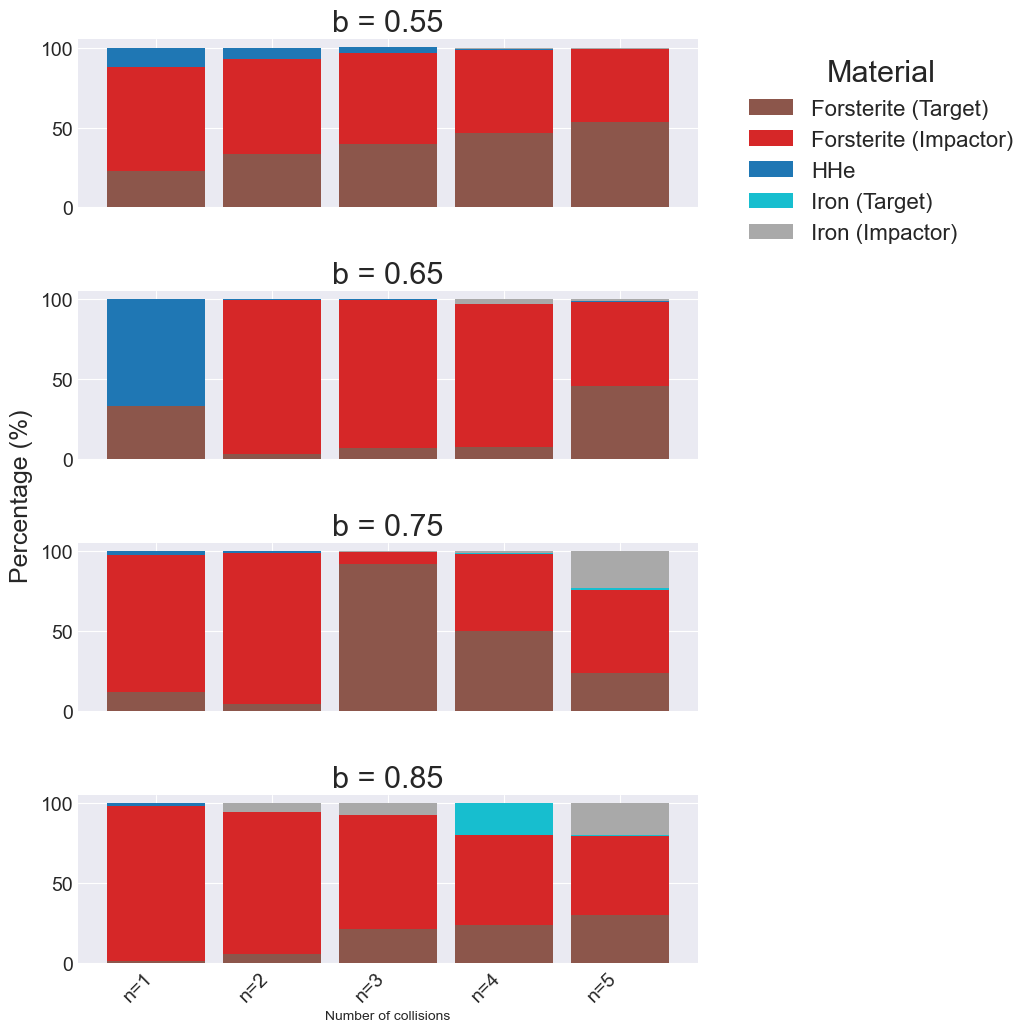

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math

## Code to store and plot composition figure 
data = {
    "b0.55n1": {
        "Forsterite (Target)": 22.59, 
        "Forsterite (Impactor)": 65.25, 
        "HHe": 12.16, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.55n2": {
        "Forsterite (Target)": 33.33, 
        "Forsterite (Impactor)": 59.57, 
        "HHe": 7.1, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.55n3": {
        "Forsterite (Target)": 39.58, 
        "Forsterite (Impactor)": 57.58, 
        "HHe": 3.29, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.55n4": {
        "Forsterite (Target)": 46.83, 
        "Forsterite (Impactor)": 52.14, 
        "HHe": 0.35, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0.68
    },
    "b0.55n5": {
        "Forsterite (Target)": 53.31, 
        "Forsterite (Impactor)": 46.19, 
        "HHe": 0, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0.5
    },
    "b0.65n1": {
        "Forsterite (Target)": 33.33, 
        "Forsterite (Impactor)": 0, 
        "HHe": 66.67, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.65n2": {
        "Forsterite (Target)": 3.03, 
        "Forsterite (Impactor)": 96.74, 
        "HHe": 0.16, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0.076
    },
    "b0.65n3": {
        "Forsterite (Target)": 6.79, 
        "Forsterite (Impactor)": 93.05, 
        "HHe": 0.16, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.65n4": {
        "Forsterite (Target)": 7.79, 
        "Forsterite (Impactor)": 89.5, 
        "HHe": 0, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 2.71
    },
    "b0.65n5": {
        "Forsterite (Target)": 45.61, 
        "Forsterite (Impactor)": 52.96, 
        "HHe": 0.29, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 1.14
    },
    "b0.75n1": {
        "Forsterite (Target)": 12.18, 
        "Forsterite (Impactor)": 85.84, 
        "HHe": 1.97, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.75n2": {
        "Forsterite (Target)": 4.79, 
        "Forsterite (Impactor)": 94.19, 
        "HHe": 1.01, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.75n3": {
        "Forsterite (Target)": 91.9, 
        "Forsterite (Impactor)": 7.89, 
        "HHe": 0.1, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0.11
    },
    "b0.75n4": {
        "Forsterite (Target)": 50.03, 
        "Forsterite (Impactor)": 48.36, 
        "HHe": 0.09, 
        "Iron (Target)": 0.79, 
        "Iron (Impactor)": 0.74,
    },
    "b0.75n5": {
        "Forsterite (Target)": 24.11, 
        "Forsterite (Impactor)": 51.77, 
        "HHe": 0.1, 
        "Iron (Target)": 0.89, 
        "Iron (Impactor)": 23.13
    },
    "n=1": {
        "Forsterite (Target)": 1.58, 
        "Forsterite (Impactor)": 97.07, 
        "HHe": 1.35, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "n=2": {
        "Forsterite (Target)": 6.15,  
        "Forsterite (Impactor)": 88.16, 
        "HHe": 0.13, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 5.56
    },
    "n=3": {
        "Forsterite (Target)": 21.5, 
        "Forsterite (Impactor)": 71.4, 
        "HHe": 0.12, 
        "Iron (Target)": 0,
        "Iron (Impactor)": 6.97
    },
    "n=4": {
        "Forsterite (Target)": 24.27, 
        "Forsterite (Impactor)": 55.66, 
        "HHe": 0.13, 
        "Iron (Target)": 19.94, 
        "Iron (Impactor)": 0
    },
    "n=5": {
        "Forsterite (Target)": 30.5, 
        "Forsterite (Impactor)": 48.87, 
        "HHe": 0, 
        "Iron (Target)": 0.69, 
        "Iron (Impactor)": 19.93
    },
}
# Convert dictionary into a DataFrame
df = pd.DataFrame(data).T
df.index.name = "Number of collisions"

# Define number of simulations per row for plotting
simulations_per_row = 5
total_simulations = len(df)
rows = math.ceil(total_simulations / simulations_per_row)

# Define colours for the composite materials.
colours = {
    "Forsterite (Target)": "#8c564b",
    "Forsterite (Impactor)": "#d62728",
    "HHe": "#1f77b4",
    "Iron (Target)": "#17becf",
    "Iron (Impactor)": "#a9a9a9"
}



# Create subplots with reduced spacing
fig, axes = plt.subplots(rows, 1, figsize=(8, 3 * rows), sharex=True, gridspec_kw={'hspace': 0.5})

# Ensure axes is a list even if only one row exists
if rows == 1:
    axes = [axes]

# Set font sizes
title_fontsize = 22
label_fontsize = 18
tick_fontsize = 14
legend_fontsize = 16

# Plot each group of simulations
for i in range(rows):
    start = i * simulations_per_row
    end = start + simulations_per_row
    subset_df = df.iloc[start:end]

    # Order the DataFrame columns according to the colours dictionary
    ordered_cols = [col for col in colours.keys() if col in subset_df.columns]
    subset_df = subset_df[ordered_cols]

    subset_df.plot(kind='bar', stacked=True, ax=axes[i],
                   color=[colours[col] for col in ordered_cols], width=0.85)

  
    axes[i].tick_params(axis='x', labelsize=tick_fontsize)
    axes[i].tick_params(axis='y', labelsize=tick_fontsize)

# Set one shared y-axis label for the entire figure.
fig.text(0.04, 0.5, 'Percentage (%)', va='center', rotation='vertical', fontsize=label_fontsize)

# Adjust legend placement for clarity
axes[0].legend(title='Material', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=title_fontsize)

# Rotate x-axis labels on the bottom subplot to 45°.
for label in axes[-1].get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

# Hide legends for all other subplots
for i in range(1, rows):
    axes[i].get_legend().remove()

if rows > 0:
    axes[0].set_title('b = 0.55', fontsize=title_fontsize)
if rows > 1:
    axes[1].set_title('b = 0.65', fontsize=title_fontsize)
if rows > 2:
    axes[2].set_title('b = 0.75', fontsize=title_fontsize)
if rows > 3:
    axes[3].set_title('b = 0.85', fontsize=title_fontsize)


plt.tight_layout()
plt.savefig('config_composite_improved.png', bbox_inches='tight')
plt.show()



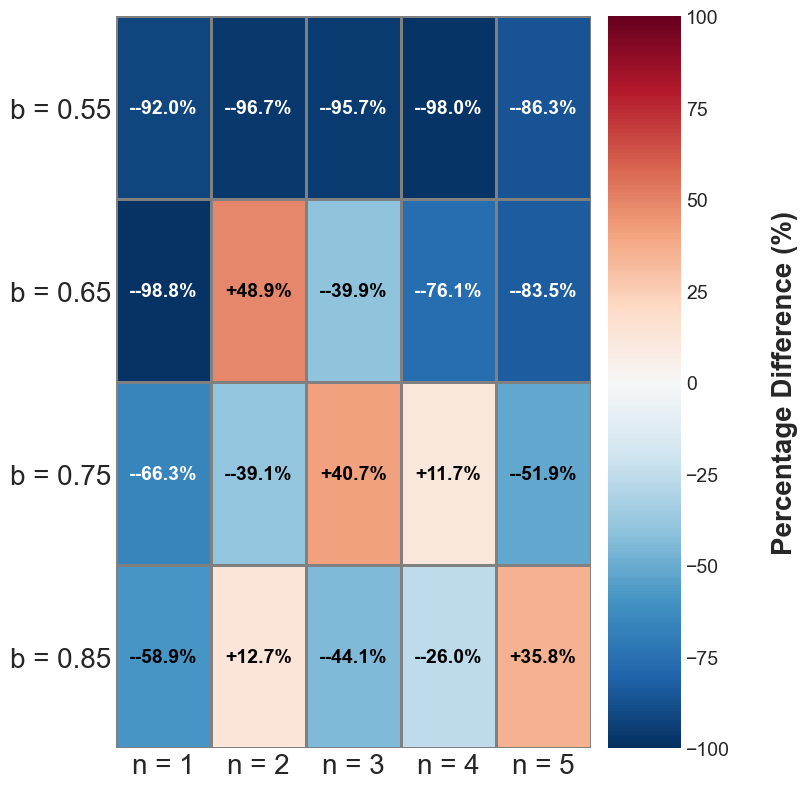

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Code which plots the heatmap of mass ratios

data = np.array([
    [0.000971, 0.0004, 0.00052, 0.00024, 0.00167],
    [0.00015, 0.0181, 0.0073, 0.0029, 0.002],
    [0.0041, 0.0074, 0.0171, 0.01357, 0.00585],
    [0.005, 0.0137, 0.0068, 0.009, 0.0165]
])

# Define the "true value" to compare against
true_value = 0.012154

# Compute percentage difference from the true value
percentage_diff = (data - true_value) / true_value * 100  # This will include positive and negative differences

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 8))  # Increase figure size

# Choose a diverging colourmap (RdBu_r for red-to-blue with white in the center)
cmap = plt.cm.RdBu_r  

# Create the heatmap with pcolormesh (removes white lines, allows better control)
c = ax.pcolormesh(percentage_diff, cmap=cmap, edgecolors='grey', linewidth=1, vmin=-100, vmax=100)

cbar = plt.colorbar(c, ax=ax, label="Percentage Difference (%)", pad=0.03, aspect=10)
cbar.ax.set_ylabel("Percentage Difference (%)", fontsize=20, fontweight="bold", labelpad=30) 

cbar.ax.tick_params(labelsize=14)

# Function which determines the brightness of a colour and return appropriate text colour (black or white)
def get_text_colour(background_colour):
    r, g, b, _ = background_colour  # Extract RGBA values
    brightness = 0.2126 * r + 0.7152 * g + 0.0722 * b  # Luminosity formula
    return 'white' if brightness < 0.5 else 'black'  # If brightness is low, use white text, otherwise black

# Annotate each cell with its percentage difference
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        sign = "+" if data[i, j] > true_value else "-"  # Determine if the value is greater or less than the true value
        
        # Get the background colour of the current cell from the colourmap
        cell_background_colour = cmap((percentage_diff[i, j] - (-100)) / (100 - (-100)))  # Normalize to [0, 1]
        
        # Determine the appropriate text colour based on background brightness
        text_colour = get_text_colour(cell_background_colour)
        
        # Annotate with percentage difference and the appropriate text colour
        ax.text(j + 0.5, i + 0.5, f"{sign}{percentage_diff[i, j]:.1f}%", ha='center', va='center', color=text_colour, fontsize=14, fontweight='bold')

# Define custom labels for the axes
x_labels = ["n = 1", "n = 2", "n = 3", "n = 4", "n = 5"]  # Custom labels for x-axis
y_labels = ["b = 0.55", "b = 0.65", "b = 0.75", "b = 0.85"]  # Custom labels for y-axis

# Set labels for the ticks
ax.set_xticks(np.arange(data.shape[1]) + 0.5)
ax.set_yticks(np.arange(data.shape[0]) + 0.5)
ax.set_xticklabels(x_labels, fontsize=20)
ax.set_yticklabels(y_labels, fontsize=20)

# Make it look clean
# ax.set_title(f"Heatmap of % Difference from true Earth-Moon mass ratio.", fontsize=16, fontweight='bold')
ax.invert_yaxis()  # Keep (0,0) at the top-left (like a normal matrix)
ax.set_frame_on(False)  # Remove border

# Tight layout to ensure everything fits without clipping
plt.tight_layout()

# Save and show the plot
plt.savefig('mass_map.png')
plt.show()


C:\Users\oscar\AppData\Local\Temp\ipykernel_3488\96021836.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


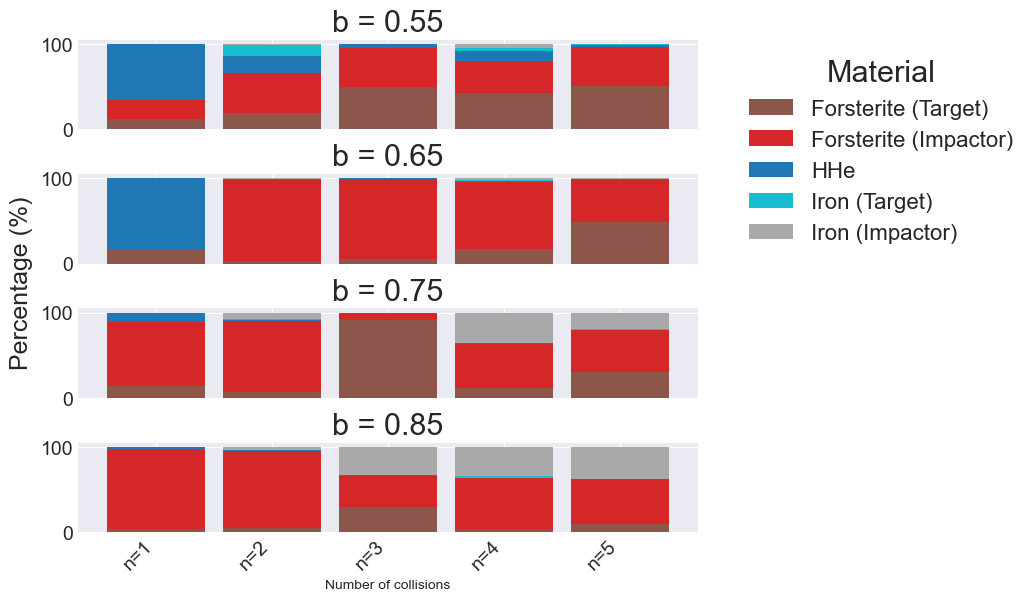

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math

## data before keplerian filtering 
data = {
    "b0.55n1": {
        "Forsterite (Target)": 12.31, 
        "Forsterite (Impactor)": 22.37, 
        "HHe": 65.28, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.55n2": {
        "Forsterite (Target)": 18.42, 
        "Forsterite (Impactor)": 47.38, 
        "HHe": 19.48, 
        "Iron (Target)": 12.86, 
        "Iron (Impactor)": 1.86
    },
    "b0.55n3": {
        "Forsterite (Target)": 49.06, 
        "Forsterite (Impactor)": 46.52, 
        "HHe": 4.42, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.55n4": {
        "Forsterite (Target)": 42.56, 
        "Forsterite (Impactor)": 37.62, 
        "HHe": 11.27, 
        "Iron (Target)": 3.42, 
        "Iron (Impactor)": 5.13
    },
    "b0.55n5": {
        "Forsterite (Target)": 50.69, 
        "Forsterite (Impactor)": 45.56, 
        "HHe": 2.84, 
        "Iron (Target)": 0.46, 
        "Iron (Impactor)": 0.46
    },
    "b0.65n1": {
        "Forsterite (Target)": 16.14, 
        "Forsterite (Impactor)": 0, 
        "HHe": 83.86, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.65n2": {
        "Forsterite (Target)": 3.33, 
        "Forsterite (Impactor)": 95.04, 
        "HHe": 0.83, 
        "Iron (Target)": 0.42, 
        "Iron (Impactor)": 0.38
    },
    "b0.65n3": {
        "Forsterite (Target)": 5.45, 
        "Forsterite (Impactor)": 94.11, 
        "HHe": 0.44, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "b0.65n4": {
        "Forsterite (Target)": 17.07, 
        "Forsterite (Impactor)": 78.7, 
        "HHe": 0.95, 
        "Iron (Target)": 1.16, 
        "Iron (Impactor)": 2.12
    },
    "b0.65n5": {
        "Forsterite (Target)": 48.13, 
        "Forsterite (Impactor)": 49.66, 
        "HHe": 1.23, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0.99
    },
    "b0.75n1": {
        "Forsterite (Target)": 13.76, 
        "Forsterite (Impactor)": 74.92, 
        "HHe": 10.92, 
        "Iron (Target)": 0.4, 
        "Iron (Impactor)": 0
    },
    "b0.75n2": {
        "Forsterite (Target)": 7.29, 
        "Forsterite (Impactor)": 82.61, 
        "HHe": 1.66, 
        "Iron (Target)": 1.35, 
        "Iron (Impactor)": 7.08
    },
    "b0.75n3": {
        "Forsterite (Target)": 90.79, 
        "Forsterite (Impactor)": 8.47, 
        "HHe": 0.43, 
        "Iron (Target)": 0.05, 
        "Iron (Impactor)": 0.27
    },
    "b0.75n4": {
        "Forsterite (Target)": 11.58, 
        "Forsterite (Impactor)": 51.98, 
        "HHe": 0.29, 
        "Iron (Target)": 0.2, 
        "Iron (Impactor)": 35.94
    },
    "b0.75n5": {
        "Forsterite (Target)": 30.04, 
        "Forsterite (Impactor)": 49.27, 
        "HHe": 0.55, 
        "Iron (Target)": 0.84, 
        "Iron (Impactor)": 18.91
    },
    "n=1": {
        "Forsterite (Target)": 4.18, 
        "Forsterite (Impactor)": 93.84, 
        "HHe": 1.98, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 0
    },
    "n=2": {
        "Forsterite (Target)": 5.58, 
        "Forsterite (Impactor)": 90.18, 
        "HHe": 0.21, 
        "Iron (Target)": 0, 
        "Iron (Impactor)": 4.03
    },
    "n=3": {
        "Forsterite (Target)": 29.77, 
        "Forsterite (Impactor)": 36.8, 
        "HHe": 0.25, 
        "Iron (Target)": 0.89,
        "Iron (Impactor)": 32.28
    },
    "n=4": {
        "Forsterite (Target)": 3.34, 
        "Forsterite (Impactor)": 60.27, 
        "HHe": 0.1, 
        "Iron (Target)": 2.33, 
        "Iron (Impactor)": 33.96
    },
    "n=5": {
        "Forsterite (Target)": 9.55, 
        "Forsterite (Impactor)": 52.42, 
        "HHe": 0.17, 
        "Iron (Target)": 0.3, 
        "Iron (Impactor)": 37.56
    },
}
# Convert dictionary into a DataFrame
df = pd.DataFrame(data).T
df.index.name = "Number of collisions"

# Define number of simulations per row for plotting
simulations_per_row = 5
total_simulations = len(df)
rows = math.ceil(total_simulations / simulations_per_row)

# Define colours for the composite materials.
colours = {
    "Forsterite (Target)": "#8c564b",
    "Forsterite (Impactor)": "#d62728",
    "HHe": "#1f77b4",
    "Iron (Target)": "#17becf",
    "Iron (Impactor)": "#a9a9a9"
}



# Create subplots with reduced spacing
fig, axes = plt.subplots(rows, 1, figsize=(8, 1.6 * rows), sharex=True, gridspec_kw={'hspace': 0.5})

# Ensure axes is a list even if only one row exists
if rows == 1:
    axes = [axes]

# Set font sizes
title_fontsize = 22
label_fontsize = 18
tick_fontsize = 14
legend_fontsize = 16

# Plot each group of simulations
for i in range(rows):
    start = i * simulations_per_row
    end = start + simulations_per_row
    subset_df = df.iloc[start:end]

    # Order the DataFrame columns according to the colours dictionary
    ordered_cols = [col for col in colours.keys() if col in subset_df.columns]
    subset_df = subset_df[ordered_cols]

    subset_df.plot(kind='bar', stacked=True, ax=axes[i],
                   color=[colours[col] for col in ordered_cols], width=0.85)

  
    axes[i].tick_params(axis='x', labelsize=tick_fontsize)
    axes[i].tick_params(axis='y', labelsize=tick_fontsize)

# Set one shared y-axis label for the entire figure.
fig.text(0.04, 0.5, 'Percentage (%)', va='center', rotation='vertical', fontsize=label_fontsize)

# Adjust legend placement for clarity
axes[0].legend(title='Material', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=title_fontsize)

# Rotate x-axis labels on the bottom subplot to 45°.
for label in axes[-1].get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

# Hide legends for all other subplots
for i in range(1, rows):
    axes[i].get_legend().remove()

if rows > 0:
    axes[0].set_title('b = 0.55', fontsize=title_fontsize)
if rows > 1:
    axes[1].set_title('b = 0.65', fontsize=title_fontsize)
if rows > 2:
    axes[2].set_title('b = 0.75', fontsize=title_fontsize)
if rows > 3:
    axes[3].set_title('b = 0.85', fontsize=title_fontsize)


plt.tight_layout()
plt.savefig('config_composite_improved.png', dpi=300)
plt.show()

In [ ]:
import os
import re
 ## Function which renames files that had to be run second time due to timeout error, so the video code can easily run
    
def rename_files(directory, last_correct_index):
    pattern = re.compile(r"coll4_run1_(\d{4})\.hdf5$")
    
    
   
    files = sorted(os.listdir(directory))
    
    
    for file in files:
        match = pattern.match(file)
        if match:
            old_index = int(match.group(1))  
            new_index = last_correct_index + 1 + old_index  
            
            old_path = os.path.join(directory, file)
            new_name = f"coll4_{new_index:04d}.hdf5" 
            new_path = os.path.join(directory, new_name)
            
           
            os.rename(old_path, new_path)
            print(f"Renamed: {file} -> {new_name}")

rename_files("final_results/b=0.75/n=5/",112) 


Renamed: coll4_run1_0000.hdf5 -> coll4_0113.hdf5
Renamed: coll4_run1_0001.hdf5 -> coll4_0114.hdf5
Renamed: coll4_run1_0002.hdf5 -> coll4_0115.hdf5
Renamed: coll4_run1_0003.hdf5 -> coll4_0116.hdf5
Renamed: coll4_run1_0004.hdf5 -> coll4_0117.hdf5
Renamed: coll4_run1_0005.hdf5 -> coll4_0118.hdf5
Renamed: coll4_run1_0006.hdf5 -> coll4_0119.hdf5
Renamed: coll4_run1_0007.hdf5 -> coll4_0120.hdf5
Renamed: coll4_run1_0008.hdf5 -> coll4_0121.hdf5
Renamed: coll4_run1_0009.hdf5 -> coll4_0122.hdf5
Renamed: coll4_run1_0010.hdf5 -> coll4_0123.hdf5
Renamed: coll4_run1_0011.hdf5 -> coll4_0124.hdf5
Renamed: coll4_run1_0012.hdf5 -> coll4_0125.hdf5
Renamed: coll4_run1_0013.hdf5 -> coll4_0126.hdf5
Renamed: coll4_run1_0014.hdf5 -> coll4_0127.hdf5
Renamed: coll4_run1_0015.hdf5 -> coll4_0128.hdf5
Renamed: coll4_run1_0016.hdf5 -> coll4_0129.hdf5
Renamed: coll4_run1_0017.hdf5 -> coll4_0130.hdf5
Renamed: coll4_run1_0018.hdf5 -> coll4_0131.hdf5
Renamed: coll4_run1_0019.hdf5 -> coll4_0132.hdf5
Renamed: coll4_run1_

In [ ]:
import os
import cv2
from tqdm import tqdm  

## Video making code


image_folder = "final_results/b=0.75/n=4/plots/"
output_video = "final_results/b=0.75/n=4/plots/anim.mp4"
frame_rate = 12

# Sorted list of PNG images in the folder
images = sorted([img for img in os.listdir(image_folder) if img.endswith(".png")])

# Load the first image to determine the video frame dimensions
first_image_path = os.path.join(image_folder, images[0])
frame = cv2.imread(first_image_path)

h, w, _ = frame.shape

# Initialize the VideoWriter object with the determined width and height
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video = cv2.VideoWriter(output_video, fourcc, frame_rate, (w, h))

# Process each image with a progress bar
for img_name in tqdm(images, desc="Processing frames"):
    img_path = os.path.join(image_folder, img_name)
    frame = cv2.imread(img_path)
    

    # Resize the frame if it doesn't match the dimensions of the first image
    if frame.shape[0] != h or frame.shape[1] != w:
        frame = cv2.resize(frame, (w, h))
    
    video.write(frame)

video.release()


Processing frames: 100%|██████████| 679/679 [01:07<00:00, 10.12it/s]


In [ ]:
import glob

# Define the directory and file pattern
directory = "final_results/b=0.65/n=1/"
directory1 = "mi/n=2/"
file_pattern1 = "n=1_coll1_*.hdf5"
file_pattern2 = "n=2_coll1_*.hdf5"
# Use glob to find all matching files
files1 = glob.glob(f"{directory}/{file_pattern1}")
files2 = glob.glob(f"{directory1}/{file_pattern2}")
# Sort files to ensure they are processed in order
files1.sort()
files2.sort()
# Loop through the files and call the function
for file_path in files1:
    init_plot(
        file_path,
        "GasParticles/Coordinates",
        "GasParticles/MaterialIDs",
        plot_range=10,
        projection="2d"
    )
    

# for file_path in files2:
#     init_plot(
#         file_path,
#         "GasParticles/Coordinates",
#         "GasParticles/MaterialIDs",
#         plot_range=20,
#         projection="2d"
#     )
